# **Сегментация клиентов интернет магазина**

В данном проекте будем решать задачу в области маркетинга. Нам предстоит произвести сегментацию клиентов на основе их покупательской способности, частоты совершения заказов и срока давности последнего заказа, а также определить оптимальную стратегию взаимодействия с ними.
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

**Бизнес-задача:** произвести сегментацию существующих клиентов и проинтерпретировать эти сегменты.

**Техническая задача:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
4. Построить эффективную модель классификации, для обновления информации о клиентах.

**Этапы работы над пректом:**
1. Загрузка данных.
2. Работа с пропусками, и очистка данных.
3. Знакомство с данными.
4. Разведывательный анализ данных.
5. RFM-сегментация клиентов.
6. Исследование полученных кластеров.
7. Классификация новых данных.
8. Подведение итогов.

In [61]:
# загрузка необходимых библиотек
import pandas as pd
import numpy as np
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d import Axes3D

from sklearn import pipeline
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn import mixture
from sklearn import manifold
from sklearn import ensemble

import warnings

sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

file_path = '/home/obukhovsv/clients_clustering/'

## **1. Загрузка данных**

**Описание данных:**

* **date** - дата проведения транзакции;
* **order_id** - ид заказа на сайте;
* **sale_id** - ид реализации. В заказе, по разным причинам, может быть несколько документов реализации;
* **site_id** - ид товара на сайте;
* **quantity** - количество каждого товара за транзакцию;
* **sum** - сумма в рублях за общее количество каждого товара в транзакции;
* **address** - адрес доставки;
* **StockCode** - код товара;
* **CustomerID** - идентификатор клиента.

Владелец интернет магазина позволил использовать базу данных только при условии обезличивания данных. Поэтому я не смог использовать такие признаки: описание товара, характеристики, имена покупателей. Название товара и имена покупателей представлены в виде уникальных идентификаторов.

In [62]:
data = pd.read_json(file_path + 'sales_data_2022.json', orient='split')

print('Исходная таблица имеет', data.shape[0], 'строки, и', data.shape[1], 'столбцов')

Исходная таблица имеет 23143357 строки, и 9 столбцов


In [63]:
data.head()

date     order_id      sale_id  site_id  quantity    sum  \
3614447 2020-10-01  УУ00-000585  УУ00-001435   2919.0       1.0  235.0   
3614448 2020-10-01  УУ00-001243  УУ00-001498   2919.0       1.0  240.0   
3614449 2020-10-01  УУ00-001368  УУ00-001425   2919.0       1.0  240.0   
3614450 2020-01-13  УУ00-001084  УУ00-002325   2919.0       2.0  465.6   
3614451 2020-01-15         None  УУ00-003102   2919.0       2.0  461.0   

        address StockCode      CustomerID  
3614447    None  421072-1   10521072-9845  
3614448    None  421072-1  10611055-16467  
3614449    None  421072-1    10471072-131  
3614450    None  421072-1  10401072-11852  
3614451    None  421072-1    10631055-654

## **2. Работа с пропусками, и очистка данных**

In [64]:
# создадим копию исходной таблицы для резерва
sales = data.copy()
sales.sort_values(by='date', inplace=True)

In [65]:
# определим количество пропусков в каждом признаке
cols_null_percent = sales.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False).round(2)
print('Количество пропусков в признаках, выраженное в процентах:')
display(cols_with_null)

Количество пропусков в признаках, выраженное в процентах:


address     70.86
order_id     2.75
site_id      0.27
sale_id      0.14
quantity     0.02
sum          0.00
dtype: float64

Удалим строки с пропусками в признаке 'site_id' (ид на сайте), так как это не торговые операции и внутренние операции с партнерами.

Удалим строки с пропусками в признаке 'sale_id' (номер реализации). Если нет номера, значит это данные из другого типа документа, случайно попавшего в наш массив.

Удалим строки с нулевыми суммами и количествами 'sum', 'quantity'. Это остатки в данных при учёте возврата. Эти строки нам будут только мешать.

In [66]:
count_before_clean = sales.shape[0]

# удалим строки с пропусками в признаках "ид на сайте", "номер реализации", "сумма", и "количество"
sales = sales.dropna(axis='index', how='any', subset=['site_id', 'sale_id', 'sum', 'quantity'])

count_after_clean = sales.shape[0]
print('В данных осталось:', count_after_clean, 'строк. Удалили', count_before_clean - count_after_clean, 'не торговых операций и мусорных данных.')
print('Это', round((count_before_clean - count_after_clean)*100 / count_before_clean, 1), '% от общего числа строк')

В данных осталось: 23078164 строк. Удалили 65193 не торговых операций и мусорных данных.
Это 0.3 % от общего числа строк


В признаке 'order_id' есть неявные пропуски.
Прии выгрузке из базы данных, вместо некоторых пропусков сгенерировались названия, начинающиеся с букв.
Номер заказа состоит только из цифр. Необходимо это учесть, и посчитать реальное количесво пропусков.

In [67]:
# определим функцию удаляющую псевдономер
def get_lost_order(order):
    if pd.isna(order): # если пропуск, возвращаем np.nan
        return np.nan
    elif order[0].isalpha(): # если начинается с буквы, возвращаем np.nan
        return np.nan
    else: # иначе оставляем как есть
        return order

# заменим псевдономер на np.nan
sales['order_id'] = sales['order_id'].apply(get_lost_order)

# посчитаем действительное количество пропусков
orders_nan = round(sales['order_id'].isnull().mean() * 100, 2)
print('Действительная часть пропусков в признаке order_id составляет:', orders_nan, '%')

Действительная часть пропусков в признаке order_id составляет: 73.08 %


Для кластеризации нам будут нужны данные за последний год. Посмотрим сколько пропусков в 'order_id' за последний год.

In [68]:
orders22_nan = round(sales[sales['date'] >= '2022-01-01']['order_id'].isnull().mean() * 100, 2)
print('Пропуски в признаке order_id за 2022 год составляют:', orders22_nan, '%')

Пропуски в признаке order_id за 2022 год составляют: 1.22 %


Признак 'order_id' (ИД заказа на сайте) будет полезен, при создании *RFM*-таблицы, т. к. пропусков за последний год чуть больше 1 %. А для создания *RFM*-таблицы нужен только год. Поэтому мы не будем его удалять.

Удалим признак 'address' с пропусками более 70 %

И удалим признак 'site_id'. Пропуски в этом признаке говорили о том, что это неторговая операция. Т. е. мы продавали то, чего нет на веб сайте, это какие-то хозяйственные операции c партнерами. Мы удалили строки с пропусками в этом признаке, поэтому он больше ненужен.

In [69]:
data.columns

Index(['date', 'order_id', 'sale_id', 'site_id', 'quantity', 'sum', 'address',
       'StockCode', 'CustomerID'],
      dtype='object')

In [70]:
sales.drop(['site_id', 'address'], axis=1, inplace=True)

# определим итоговое количество пропусков в каждом признаке
print('Итоговая часть пропусков в признаках в %:')
(sales.isnull().mean() * 100).sort_values(ascending=False).round(2)

Итоговая часть пропусков в признаках в %:


order_id      73.08
date           0.00
sale_id        0.00
quantity       0.00
sum            0.00
StockCode      0.00
CustomerID     0.00
dtype: float64

Отлично! Мы очистили данные от пропусков.

## **3. Знакомство с данными**

In [71]:
# для удобства изменим порядок столбцов
sales = sales[['date', 'order_id', 'sale_id', 'CustomerID', 'StockCode', 'quantity', 'sum']]

# изменим тип данных в числовых признаках
sales['quantity'] = sales['quantity'].astype('int16')
sales['sum'] = sales['sum'].astype('float32')
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23078164 entries, 3677649 to 26987754
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   order_id    object        
 2   sale_id     object        
 3   CustomerID  object        
 4   StockCode   object        
 5   quantity    int16         
 6   sum         float32       
dtypes: datetime64[ns](1), float32(1), int16(1), object(4)
memory usage: 1.2+ GB


In [72]:
print("В данных есть два числовых типа: 'quantity', 'sum'")
print('Данные представлены в интервале от', sales.date.min().date(), 'до', sales.date.max().date())
print('Минимальное количество по одной позиции:', sales.quantity.min())
print('Максимальное количество по одной позиции:', sales.quantity.max())
print('Минимальная сумма по одной позиции:', sales['sum'].min())
print('Максимальная сумма по одной позиции:', sales['sum'].max())
print('Всего уникальных товаров:', sales.StockCode.nunique())
print('Всего уникальных клиентов покупали товары:', sales.CustomerID.nunique())

В данных есть два числовых типа: 'quantity', 'sum'
Данные представлены в интервале от 2020-01-01 до 2022-12-30
Минимальное количество по одной позиции: 1
Максимальное количество по одной позиции: 9986
Минимальная сумма по одной позиции: 0.01
Максимальная сумма по одной позиции: 1056160.0
Всего уникальных товаров: 27485
Всего уникальных клиентов покупали товары: 64884


Кажется подозрительной минимальная сумма по одной позиции.

Также отметим, что максимальное количество по одной позиции порядка 10 000 тысяч, что может свидетельствовать об оптовом характере закупок.

### **Сначала проверим товары дешевле 10 рублей.**

In [73]:
sales[sales['sum'] < 11].sort_values(by='sum')

date order_id      sale_id      CustomerID  StockCode  quantity  \
6187320 2020-04-30      NaN  УУЦБ-064730   10511072-1809  5341-9153         1   
6948719 2020-08-05      NaN  ТНЦБ-000576      104855-710  5341-9153         1   
6948505 2020-07-05      NaN  ТНЦБ-000574      104855-710  5341-9153         1   
6947949 2020-05-05      NaN  ТНЦБ-000563      104855-710  5341-9153         1   
6947832 2020-05-05      NaN  ИТЦБ-000335     10571054-81  5341-9153         1   
...            ...      ...          ...             ...        ...       ...   
6952434 2020-05-28      NaN  УУЦБ-082212  10501072-32356  5341-9153         2   
6948844 2020-08-05      NaN  УУЦБ-068798  10411072-13443  5341-9153         2   
6948093 2020-06-05      NaN  УУЦБ-067804   10471095-1376  5341-9153         2   
6951743 2020-05-22      NaN  ДАЦБ-001805   10641072-9695  5341-9153         2   
6947521 2020-03-05      NaN  УУЦБ-065864   10411072-9599  5341-9153         5   

          sum  
6187320  0.01  
6948719  0.95  
6948505  0.95  
6947949  0.95  
6947832  0.96  
...       ...  
6952434  2.00  
6948844  2.00  
6948093  2.00  
6951743  2.00  
6947521  5.00  

[5612 rows x 7 columns]

Помним, что собственник не разрешил публиковать в проекте описания товаров, и имена клиентов.

Но для анализа я, всё-таки, их использовал.

По описанию товара, стало понятно, что товары с суммой меньше 10 рублей являются подарками от интернет магазина.

Поэтому я решил не использовать их в данных. 

In [74]:
print('Всего строк с подарками:', len(sales[sales['sum'] < 10]))

# удалим строки с подарками
sales  = sales[sales['sum'] >= 10]
print('В данных осталось', sales.shape[0], 'строк')

Всего строк с подарками: 5612
В данных осталось 23072552 строк


### **Теперь посмотрим на закупку с большим количеством единиц товара.**

In [75]:
sales[sales.quantity > 100].sort_values(by='quantity')

date order_id      sale_id      CustomerID     StockCode  \
25847084 2022-09-13      NaN  ТНЦБ-174737   10551095-2777  551103-10112   
24142065 2022-10-05      NaN  ТНЦБ-090746   10551095-2777  541081-10997   
26181142 2022-10-20   976352  ТНЦБ-196477  10411056-70874  541103-29459   
26056316 2022-10-19   961116  ТНЦБ-196202    10521054-692  501081-27194   
6008942  2020-04-17      NaN  ТНЦБ-000360   10421072-2045     4941-8628   
...             ...      ...          ...             ...           ...   
6007469  2020-05-04      NaN  УУЦБ-051438   10481095-8107     4941-8628   
6471417  2020-04-28      NaN  ТНЦБ-000466    10521054-692   105341-3283   
10738101 2020-09-09      NaN  ТНЦБ-003161  10711055-43809     4941-8627   
5202985  2020-03-30      NaN  ШПЦБ-000266     10521072-23   491086-8630   
5202997  2020-03-30      NaN  ШПЦБ-000266     10521072-23   491086-8630   

          quantity       sum  
25847084       101   54691.0  
24142065       101  172710.0  
26181142       101  113120.0  
26056316       101  110595.0  
6008942        101    8908.0  
...            ...       ...  
6007469       3190  334950.0  
6471417       3220  483000.0  
10738101      3340  178556.0  
5202985       6999  692901.0  
5202997       9986  988614.0  

[4105 rows x 7 columns]

Действительно, это похоже на оптовые закупки, и их довольно много.

### **Проверим на уникальность идентификатор реализации товаров.**

In [76]:
# возьмем какой-нибудь ИД из предидущего вывода
example_id = 'УУЦБ-051438'
sales[sales.sale_id == example_id].head(10)

date order_id      sale_id      CustomerID      StockCode  \
6007469  2020-05-04      NaN  УУЦБ-051438   10481095-8107      4941-8628   
6004512  2020-05-04      NaN  УУЦБ-051438   10481095-8107      4941-8627   
15972123 2021-03-26      NaN  УУЦБ-051438  10561072-56816  10431081-2304   
25598360 2022-08-20   956185  УУЦБ-051438  10571095-15673    105341-3207   
25561314 2022-08-20   956185  УУЦБ-051438  10571095-15673    105034-9782   
25296454 2022-08-20   956185  УУЦБ-051438  10571095-15673    491081-9861   
25294020 2022-08-20   956185  УУЦБ-051438  10571095-15673     491081-416   
25294013 2022-08-20   956185  УУЦБ-051438  10571095-15673     491081-416   
25294015 2022-08-20   956185  УУЦБ-051438  10571095-15673     491081-416   
25294016 2022-08-20   956185  УУЦБ-051438  10571095-15673     491081-416   

          quantity       sum  
6007469       3190  334950.0  
6004512         42    4410.0  
15972123         1    1510.0  
25598360         2     226.0  
25561314         1     116.0  
25296454         1     385.0  
25294020         2    1600.0  
25294013         2    1600.0  
25294015         2    1600.0  
25294016         2    1600.0

Предположение подтвердилось, идентификаторы реализаций не уникальны. По одному случайному идентификатору нашлось три разные сделки, с разными клиентами, в разные годы.

Эти ид генерировались программой 1С:ERP. У таких программ есть масса особенностей, одна из них - генерировать идентификаторы в периодах. 

Предположим, что в качестве периода - год.

Это можно проверить следующим образом:
- посчитаем количество уникальных ид в каждом году;
- посчитаем количество уникальных ид в каждом месяце;

Если количество уникальных ид одного года будет совпадать с суммой уникальных ид каждого месяца этого же года, это фактически подтвердит нашу теорию.

In [77]:
# необходимо создать признаки: год, месяц
sales['year'] = sales['date'].dt.year.astype('int16')
sales['month'] = sales['date'].dt.month.astype('int8')

# посчитаем количество уникальных реализаций в каждом году
year_sales = sales.groupby(by='year')['sale_id'].nunique()
year_sales

year
2020    198034
2021    340610
2022    300974
Name: sale_id, dtype: int64

In [78]:
# посчитаем количество уникальных реализаций в каждом месяце каждого года
month_sales = sales.groupby(by=['year', 'month'], as_index=False)['sale_id'].nunique()
display(month_sales.head(3))
display(month_sales.tail(3))

year  month  sale_id
0  2020      1    14315
1  2020      2    16225
2  2020      3    16056

year  month  sale_id
33  2022     10    22836
34  2022     11    27293
35  2022     12    22835

In [79]:
# вычислим разности суммы реализаций по месяцам и их количества за все годы
for year in list(month_sales['year'].unique()):
    diff_count_sales = month_sales[month_sales.year == year]['sale_id'].sum() - year_sales.loc[year]
    print(f'Разность суммы реализаций по месяцам и их количества за {year} год: {diff_count_sales}')

Разность суммы реализаций по месяцам и их количества за 2020 год: 280
Разность суммы реализаций по месяцам и их количества за 2021 год: 98
Разность суммы реализаций по месяцам и их количества за 2022 год: 172


Получилась небольшая разница в несколько сотен по каждому году. Это произошло потому что были предоставлены не даты создания документов реализации, а даты их проведения. Эти несколько сотен были созданы в конце одного года, а были проведены в начале другого. Таким одназом, в один год попали документы с номерами из прошлого года. И при подсчете уникальных за год они не посчитслись, отсюда и разница.

Чтобы сделать уникальный идентификатор у каждой реализации, мы добавим к номеру год и месяц. Так мы решим проблему дублей по названию во всех годах, и даже внутри года.

In [80]:
sales['year'] = sales['year'].astype('str')
sales['month'] = sales['month'].astype('str')

sales['sale_id'] = sales['year'] + sales['month'] + '-' + sales['sale_id']
sales.head(2)

date order_id            sale_id     CustomerID      StockCode  \
3677649 2020-01-01      NaN  20201-УУ00-000001  10551095-2777     491103-694   
4148660 2020-01-01      NaN  20201-УУ00-000002  10551095-2777  10571103-5686   

         quantity      sum  year month  
3677649        20   7600.0  2020     1  
4148660        40  25840.0  2020     1

## **4. Разведывательный анализ данных**

Перед нами стоят следующие задачи:
* подробнее рассмотреть информацию по заказам на сгруппированных данных;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.

### **Построим визуализацию, отражающую распределение сумм от реализаций, количества товаров в заказе.**

In [81]:
# сгруппируем данные по заказам, и сосчитаем суммы и количества
sales_sum = sales.groupby(by='sale_id')['sum', 'quantity'].sum().reset_index()
# посмотрим на описательную статистику по заказам
sales_sum.describe().style.format({'quantity': '{:.2f}', 'sum': '{:.2f}'})

Для того, чтобы гистограммы выглядели наглядно, ограничим их зашкаливающие значения. Возьмем данные из описательной статистики. Пределом будет значение чуть меньше удвоенного среднего.

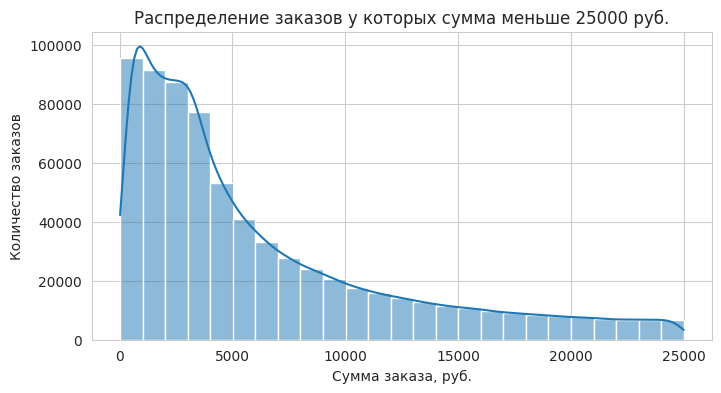

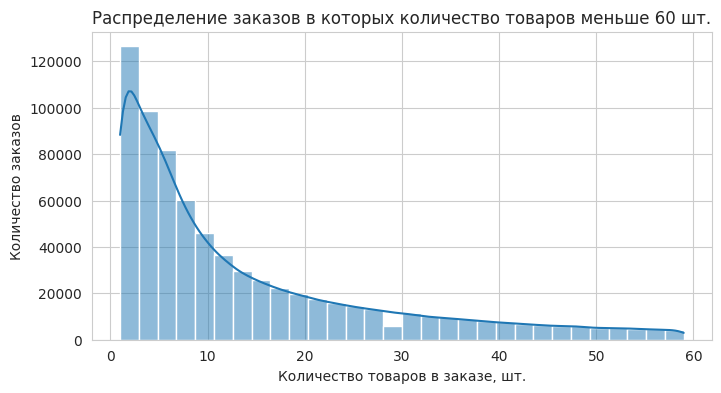

In [82]:
# построим гистограммы
fig = plt.figure(figsize=(8,4))
his1 = sns.histplot(
    data=sales_sum[sales_sum['sum'] < 25000],
    x='sum',
    bins=25,
    kde=True
);
his1.set_title('Распределение заказов у которых сумма меньше 25000 руб.');
his1.set_xlabel('Сумма заказа, руб.');
his1.set_ylabel('Количество заказов');
fig.show();

print()

fig = plt.figure(figsize=(8,4))
his2 = sns.histplot(
    data=sales_sum[sales_sum['quantity'] < 60],
    x='quantity',
    bins=30,
    kde=True
);
his2.set_title('Распределение заказов в которых количество товаров меньше 60 шт.');
his2.set_xlabel('Количество товаров в заказе, шт.');
his2.set_ylabel('Количество заказов');
fig.show();

Итого: средняя сумма заказа в интернет магазине составляет: 16715.02 рублей, а среднее количество товаров в заказе: 37 штук.

**Вывод:** исходя их этих данных можно утверждать, что интернет магазин нацелен на оптовую торговлю.

### **Распределения по временным интервалам: год, месяц, день недели.**

Добавим в таблицу с транзакциями признаки года, месяца, и дня недели совершения покупки.

In [83]:
# вернем признакам 'year' и 'month' числовые типы, и добавим признак дня недели
sales['year'] = sales['year'].astype('int16')
sales['month'] = sales['month'].astype('int8')
sales['dayofweek'] = sales['date'].dt.dayofweek.astype('int8')

Построим визуализацию, отражающую распределение суммарной выручки от реализаций **по годам**.

Визуализацию, отражающую распределение количества реализаций **по годам**.

И визуализацию, отражающую распределение количества покупателей **по годам**.

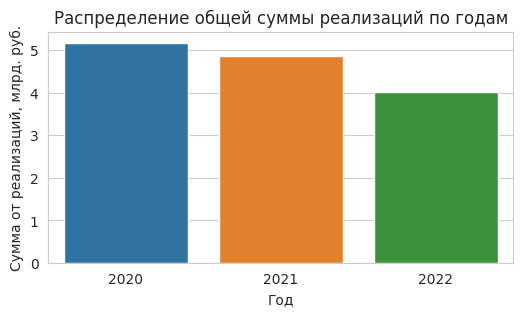

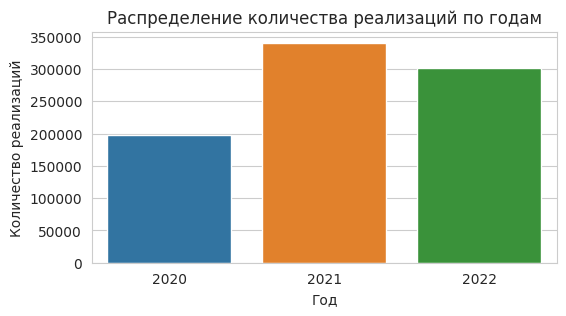

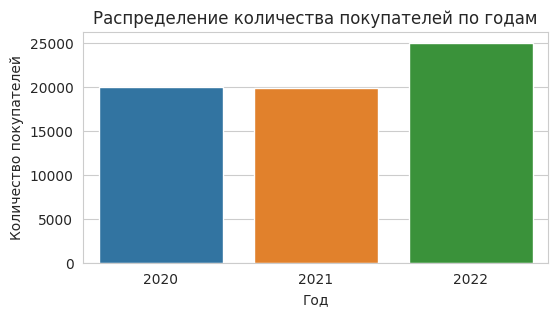

In [84]:
# сгруппируем данные просумировав выручку от реализаций по каждому году
revenue_year = sales.groupby(by=['year'])['sum'].sum() / 1000000000

# построим визуализацию, отражающую распределение общей суммы реализаций по годам
sns.set_style("whitegrid")
fig = plt.figure(figsize=(6, 3))
barplot = sns.barplot(
    x=revenue_year.index,
    y=revenue_year.values
)
barplot.set_title('Распределение общей суммы реализаций по годам');
plt.ticklabel_format(style='plain', axis='y')
barplot.set_xlabel('Год')
barplot.set_ylabel('Сумма от реализаций, млрд. руб.');
fig.show();

print()

# сгруппируем данные по реализаций
orders_years = sales.groupby(by=['sale_id'])['year'].max().reset_index()
# посчитаем количество реализаций в каждом году
orders_years = orders_years.groupby(by=['year'])['sale_id'].count()

# построим визуализацию, отражающую распределение количества реализаций по годам
fig = plt.figure(figsize=(6, 3))
barplot = sns.barplot(
    x=orders_years.index,
    y=orders_years.values
)
barplot.set_title('Распределение количества реализаций по годам');
plt.ticklabel_format(style='plain', axis='y')
barplot.set_xlabel('Год')
barplot.set_ylabel('Количество реализаций');
fig.show();

print()

orders_years = (
    sales
    # сгруппируем данные по покупателям
    .groupby(by=['CustomerID'])['year'].max()
    .reset_index()
    # посчитаем количество покупателей в каждом году
    .groupby(by=['year'])['CustomerID'].count()
    )

# построим визуализацию, отражающую распределение количества покупателей по годам
fig = plt.figure(figsize=(6, 3))
barplot = sns.barplot(
    x=orders_years.index,
    y=orders_years.values
)
barplot.set_title('Распределение количества покупателей по годам');
plt.ticklabel_format(style='plain', axis='y')
barplot.set_xlabel('Год')
barplot.set_ylabel('Количество покупателей');
fig.show();

**Вывод:** по распределениям видно, что сумма годовых реализации товаров падают от года к году. Можно предположить, что это связано с повышением конкуренции на рынке, или общем снижении интереса к товарам этого магазина. Или может, это снижение эфективности интернет магазина.

Вероятно на это могли повлиять события в РФ:
 * **2021 г.** - КОВИД, и ограничительные меры;
 * **2022 г.** - начало СВО.

Также по графику распределения количества реализаций видно, что 2021 год почти вдвое опережает 2020 год по количеству реализаций. Что говорит нам об увеличении документооборота.

В распределении количества покупателей 2022 год растет на 25% по отношению к предидущим, при том что сумма не растет. Это может свидетельствовать о смещении в сторону сегмента розничной торговли.

Построим визуализацию, отражающую распределение суммарной выручки от реализаций **по месяцам**.

Визуализацию, отражающую распределение среднего количества реализаций **по месяцам**.

И визуализацию, отражающую распределение среднего количества покупателей **по месяцам**.

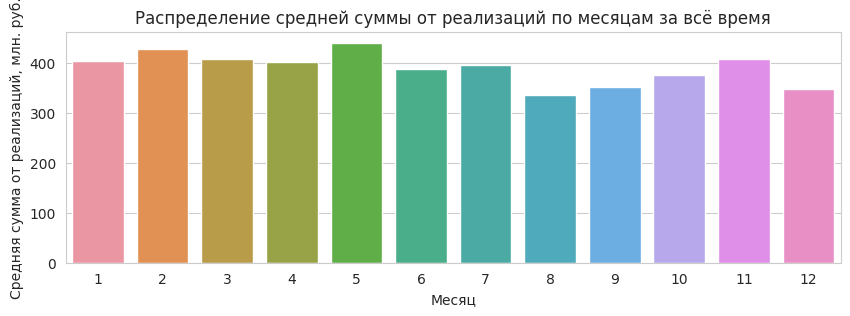

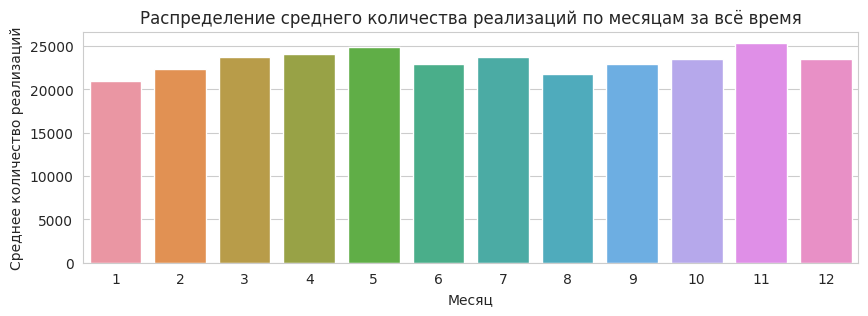

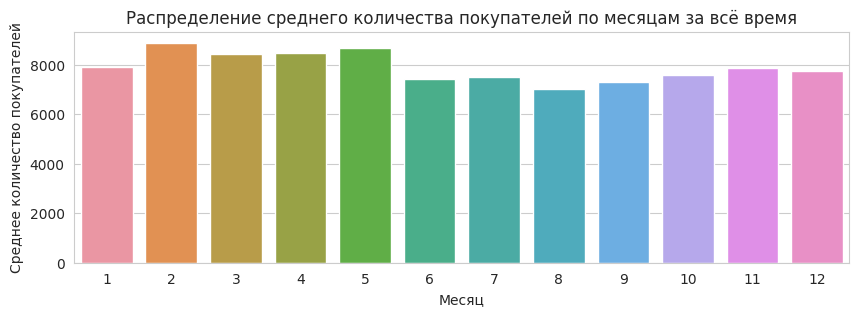

In [89]:
# сгруппируем данные просумировав выручку от реализаций по каждому месяцу, а затем вычислим среднюю выручку по месяцам за всё время
mean_revenue_month = (
    sales
    .groupby(by=['year', 'month'])['sum'].sum()
    .groupby(by=['month']).mean()
    / 1000000
)

# построим визуализацию, отражающую распределение средней суммы реализаций по месяцам
fig = plt.figure(figsize=(10, 3))
barplot = sns.barplot(
    x=mean_revenue_month.index,
    y=mean_revenue_month.values
)
barplot.set_title('Распределение средней суммы от реализаций по месяцам за всё время');
plt.ticklabel_format(style='plain', axis='y')
barplot.set_xlabel('Месяц')
barplot.set_ylabel('Средняя сумма от реализаций, млн. руб.');
fig.show();

print()

# сгруппируем данные по реализациям
orders_months = sales.groupby(by=['sale_id'])['year', 'month'].max().reset_index()
# посчитаем количество реализаций в каждом месяце каждого года
orders_months = orders_months.groupby(by=['year', 'month'])['sale_id'].count()
# расчитаем среднее количество реализаций за все годы в каждом месяце
mean_count_month = orders_months.groupby(by=['month']).mean()

# построим визуализацию, отражающую распределение среднего количества реализаций по месяцам
fig = plt.figure(figsize=(10, 3))
barplot = sns.barplot(
    x=mean_count_month.index,
    y=mean_count_month.values
)
barplot.set_title('Распределение среднего количества реализаций по месяцам за всё время');
plt.ticklabel_format(style='plain', axis='y')
barplot.set_xlabel('Месяц')
barplot.set_ylabel('Среднее количество реализаций');
fig.show();

print()

mean_count_month = (
    sales
    .groupby(by=['year', 'month'])['CustomerID'].nunique()
    .reset_index()
    # расчитаем среднее количество реализаций за все годы в каждом месяце
    .groupby(by=['month'])['CustomerID'].mean()
    )

# построим визуализацию, отражающую распределение среднего количества реализаций по месяцам
fig = plt.figure(figsize=(10, 3))
barplot = sns.barplot(
    x=mean_count_month.index,
    y=mean_count_month.values
)
barplot.set_title('Распределение среднего количества покупателей по месяцам за всё время');
plt.ticklabel_format(style='plain', axis='y')
barplot.set_xlabel('Месяц')
barplot.set_ylabel('Среднее количество покупателей');
fig.show();

**Вывод:** по распределениям видно, что диаграммы распределения сумм и реализаций за весь год держатся приблизительно на одном уровне. Можно отметить небольшой рост к середине года, и к концу. Это можно обьяснить тем, что клиенты начинают закупаться к новогодним праздникам, потом спрос немного снижается.

Теперь посмотрим на графики реализаций, их суммы, и количества проданных товаров от месяца к месяцу.

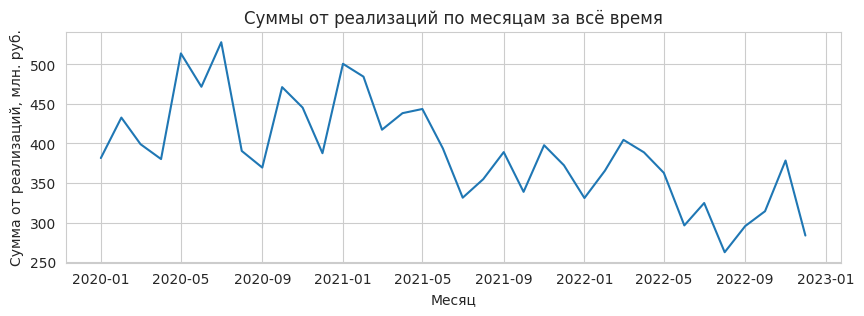

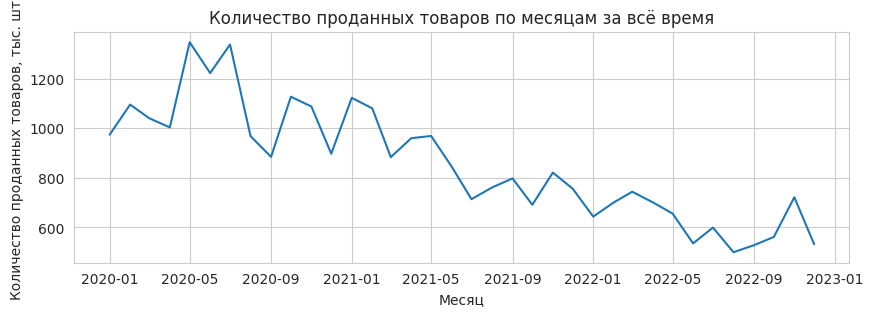

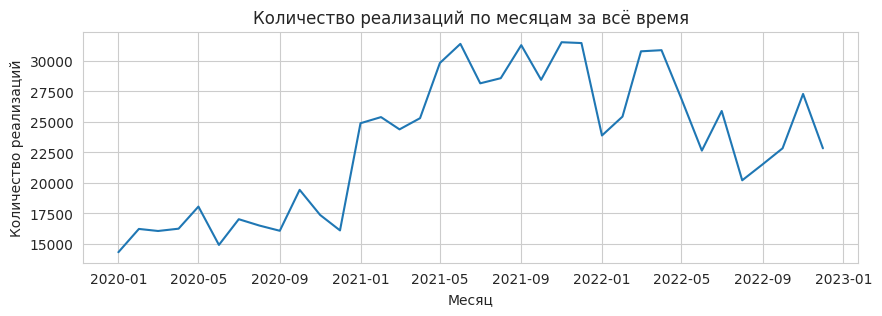

In [26]:
# посчитаем суммы от реализаций по каждому месяуцу
months_sum = sales.groupby(by=['year', 'month'])['sum'].sum().reset_index()
# объединим год и месяц в дату для дальнейшей визуализации
months_sum['date'] = months_sum['year'].astype(str) + '-' + months_sum['month'].astype(str)
months_sum['date'] = pd.to_datetime(months_sum['date'])
# выразим суммы в млн. рублей
months_sum['sum'] = months_sum['sum'] / 1000000

# построим линейный график
fig = plt.figure(figsize=(10, 3))
months_plot = sns.lineplot(
    data=months_sum,
    x='date',
    y='sum'
    )

months_plot.set_title('Суммы от реализаций по месяцам за всё время');
months_plot.set_xlabel('Месяц');
months_plot.set_ylabel('Сумма от реализаций, млн. руб.');
# months_plot.grid()
fig.show();

print()

# посчитаем количество проданных товаров по каждому месяуцу
months_count = sales.groupby(by=['year', 'month'])['quantity'].sum().reset_index()
# объединим год и месяц в дату для дальнейшей визуализации
months_count['date'] = months_count['year'].astype(str) + '-' + months_count['month'].astype(str)
months_count['date'] = pd.to_datetime(months_count['date'])
# выразим суммы в млн. рублей
months_count['quantity'] = months_count['quantity'] / 1000

# построим линейный график
fig = plt.figure(figsize=(10, 3))
months_plot = sns.lineplot(
    data=months_count,
    x='date',
    y='quantity'
    )

months_plot.set_title('Количество проданных товаров по месяцам за всё время');
months_plot.set_xlabel('Месяц');
months_plot.set_ylabel('Количество проданных товаров, тыс. шт.');
fig.show();

print()

# сгруппируем данные по реализациям
orders_months = sales.groupby(by=['sale_id'])['year', 'month'].max().reset_index()
# посчитаем количество реализаций в каждом месяце каждого года
orders_months = orders_months.groupby(by=['year', 'month'])['sale_id'].count().reset_index()
# объединим год и месяц в дату для дальнейшей визуализации
orders_months['date'] = orders_months['year'].astype(str) + '-' + orders_months['month'].astype(str)
orders_months['date'] = pd.to_datetime(orders_months['date'])

# построим линейный график
fig = plt.figure(figsize=(10, 3))
months_plot = sns.lineplot(
    data=orders_months,
    x='date',
    y='sale_id'
    )

months_plot.set_title('Количество реализаций по месяцам за всё время');
months_plot.set_xlabel('Месяц');
months_plot.set_ylabel('Количество реализаций');
fig.show();

**Вывод:** по месячномуграфику видно, что сильный рост количества реализаций был в начале 2021 года, и в середине. При этом по графикам сумм, и количества проданных товаров резких скачков не наблюдается. Вероятнее всего, это результат внутренней реорганизации бизнес механизмов.

Построим визуализацию, отражающую распределение средней выручки от реализаций по дням недели за всё время (без учета возвратов)

И визуализацию, отражающую распределение среднего количества реализаций по дням недели.

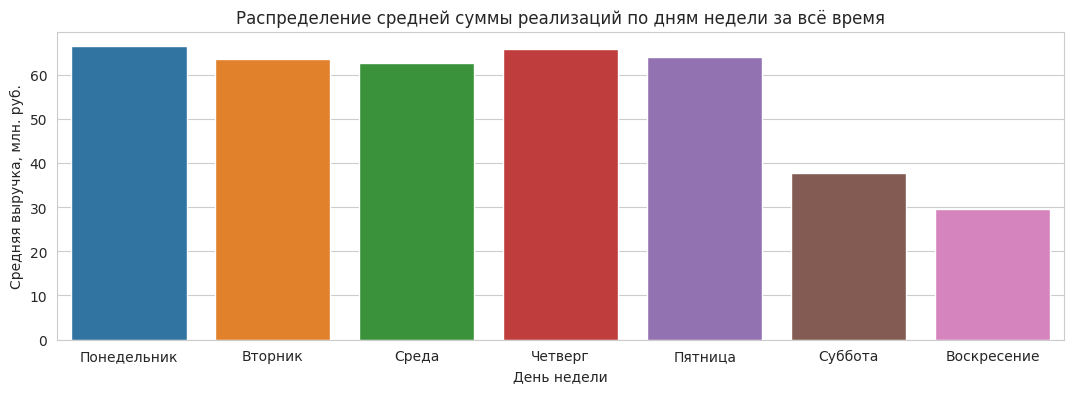

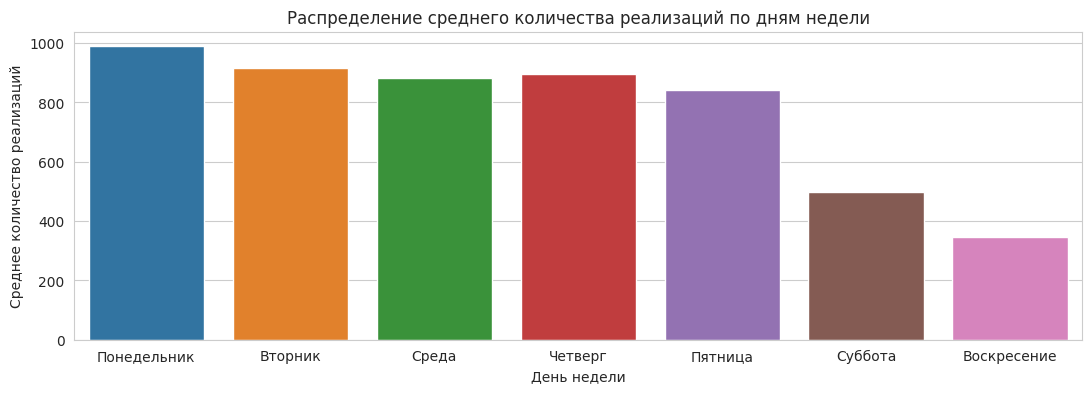

In [27]:
mean_revenue_weeks = (
    sales
    # сгруппируем данные просумировав выручку от реализаций по каждому месяцу
    .groupby(by=['year', 'month', 'dayofweek'])['sum'].sum()
    # сгруппируем данные по дням недели и вычислим среднюю выручку
    .groupby(by=['dayofweek']).mean() / 1000000
    )

# построим визуализацию, отражающую распределение средней суммы реализаций по дням недели
fig = plt.figure(figsize=(13, 4))
barplot = sns.barplot(
    x=mean_revenue_weeks.index,
    y=mean_revenue_weeks.values
)
barplot.set_title('Распределение средней суммы реализаций по дням недели за всё время');
barplot.set_xticklabels(['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресение'])
plt.ticklabel_format(style='plain', axis='y')
barplot.set_xlabel('День недели')
barplot.set_ylabel('Средняя выручка, млн. руб.');
fig.show();

print()

orders_weeks = (
    sales
    # сгруппируем данные по реализациям
    .groupby(by=['sale_id'])['year', 'month', 'dayofweek'].max()
    .reset_index()
    # посчитаем количество реализаций в каждом дне недели
    .groupby(by=['year', 'month', 'dayofweek'])['sale_id'].count()
    / 4.34524 # разделим на среднее число недель в месяце
    )

# расчитаем среднее количество реализаций в каждом дне недели за всё время
quantity_dow = orders_weeks.groupby(by=['dayofweek']).mean()

# построим визуализацию, отражающую распределение суммарной выручки от реализаций по месяцам
fig = plt.figure(figsize=(13, 4))
barplot = sns.barplot(
    x=quantity_dow.index,
    y=quantity_dow.values
)
barplot.set_title('Распределение среднего количества реализаций по дням недели');
barplot.set_xticklabels(['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресение'])
barplot.set_xlabel('День недели')
barplot.set_ylabel('Среднее количество реализаций');
fig.show();

**Вывод:** по диаграмме видно, что в будние дни средняя выручка и количество реализаций держатся примерно на одном уровне, а на выходных снижается. На выходных не так много людей занимается онлайн шопингом, и тем более отдыхают те, кто занимается этим профессионально.

### **Посмотрим на топы по покупателям и продуктам.**

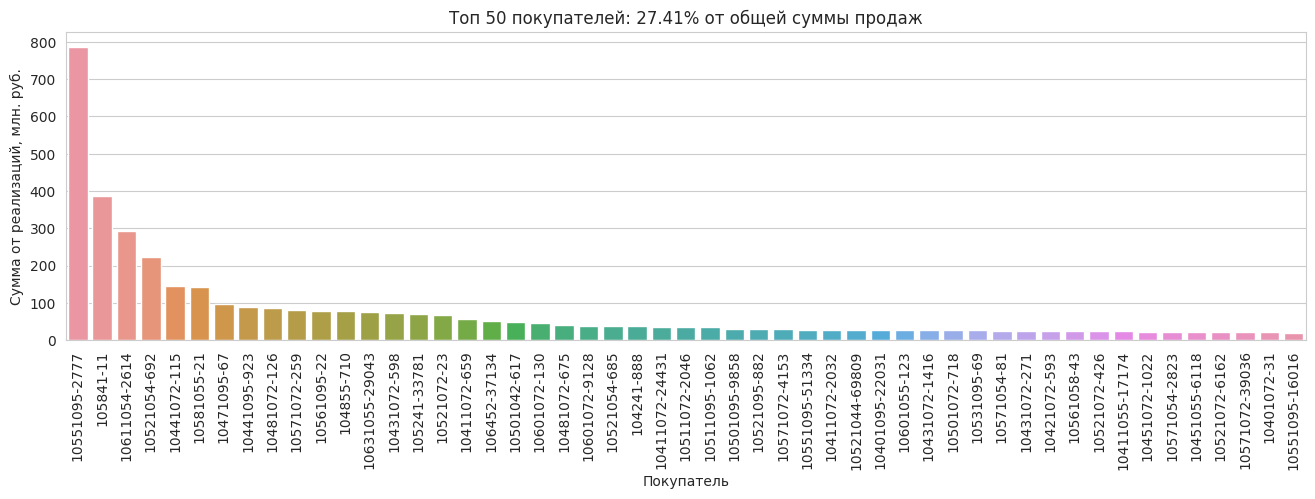

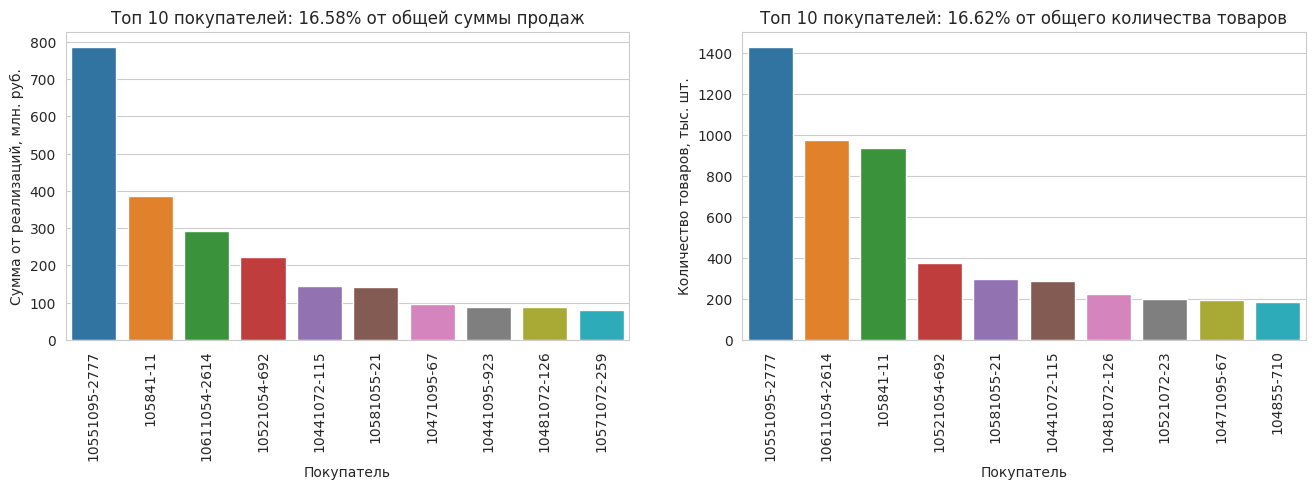

<Figure size 1600x400 with 0 Axes>

In [28]:
# посчитаем сколько потратил каждый покупатель, и отсоритруем по убыванию
customer_top = sales.groupby(["CustomerID"])['sum'].sum().sort_values(ascending = False)

# посчитаем процент топ 50-ти от общей суммы продаж за 3 года
percent_sales = np.round((customer_top[:51].sum() / customer_top.sum()) * 100, 2)

fig = plt.figure(figsize=(16, 4))
barplot = sns.barplot(
    x=customer_top[:51].index,
    y=customer_top[:51].values/1000000
)
barplot.set_title('Топ 50 покупателей: {:3.2f}% от общей суммы продаж'.format(percent_sales));
barplot.set_xlabel('Покупатель')
barplot.set_ylabel('Сумма от реализаций, млн. руб.');
plt.xticks(rotation=90)
fig.show();

# посчитаем процент топ 10-ти от общей суммы продаж за 3 года
percent_sales = np.round((customer_top[:10].sum() / customer_top.sum()) * 100, 2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

fig = plt.figure(figsize=(16, 4));
barplot = sns.barplot(
    x=customer_top[:10].index,
    y=customer_top[:10].values/1000000,
    ax=axes[0]
);
barplot.set_title('Топ 10 покупателей: {:3.2f}% от общей суммы продаж'.format(percent_sales));
barplot.set_xlabel('Покупатель');
barplot.set_ylabel('Сумма от реализаций, млн. руб.');
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation = 90);
fig.show();

# посчитаем количество товаров которые кипил каждый покупатель, и отсоритруем по убыванию
customer_top = sales.groupby(["CustomerID"])['quantity'].sum().sort_values(ascending = False)

# посчитаем процент топ 10-ти от общего количества проданных товаров за 3 года
percent_sales = np.round((customer_top[:10].sum() / customer_top.sum()) * 100, 2)

barplot = sns.barplot(
    x=customer_top[:10].index,
    y=customer_top[:10].values/1000,
    ax=axes[1]
);
barplot.set_title('Топ 10 покупателей: {:3.2f}% от общего количества товаров'.format(percent_sales));
barplot.set_xlabel('Покупатель');
barplot.set_ylabel('Количество товаров, тыс. шт.');
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation = 90);
fig.show();

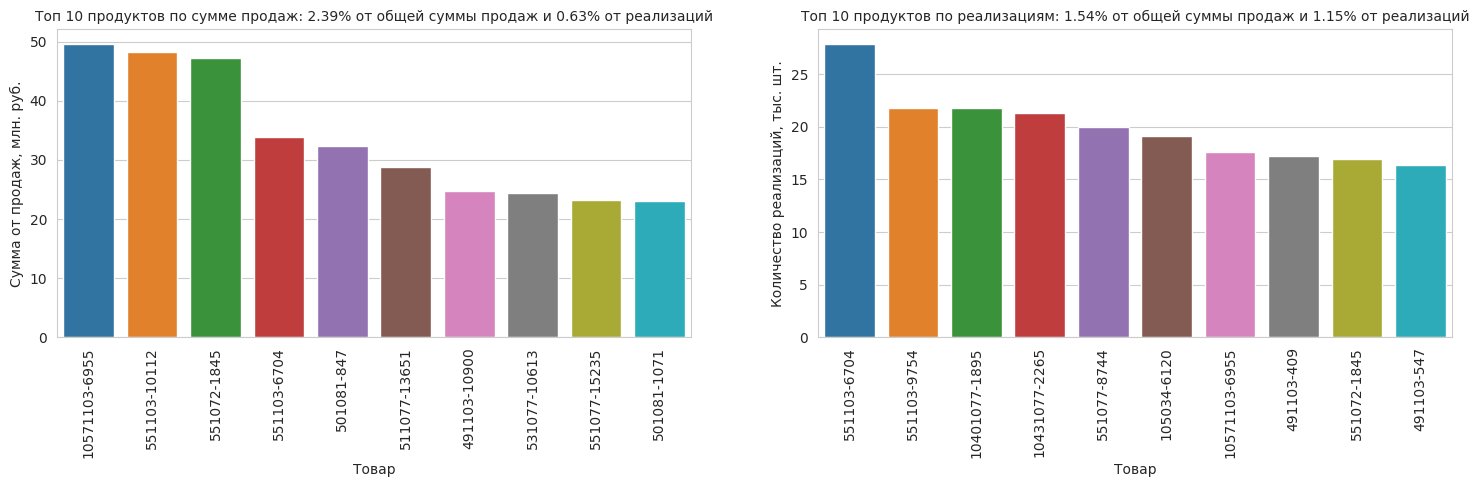

<Figure size 1600x400 with 0 Axes>

<Figure size 1600x400 with 0 Axes>

In [29]:
# сгруппируем данные по товарам, просуммировав выручку
goods_sum_top = sales.groupby(["StockCode"])['sum'].sum().sort_values(ascending = False)
# сгруппируем данные по товарам, просуммировав количество заказов, в которых фигурировал этот товар
goods_orders_top = sales[["StockCode", "sale_id"]].groupby(["StockCode"]).sale_id.nunique().sort_values(ascending = False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))

# запишем в список топ 10 продуктов по сумме продаж
top10 = list(goods_sum_top[:10].index)
# посчитаем проценты по суммам продаж и количеству реализаций
percent_sales =  np.round((goods_sum_top[top10].sum()/goods_sum_top.sum()) * 100, 2)
percent_events = np.round((goods_orders_top[top10].sum()/goods_orders_top.sum()) * 100, 2)

# построим диаграмму
fig = plt.figure(figsize=(16, 4));
barplot = sns.barplot(
    x=goods_sum_top[top10].index,
    y=goods_sum_top[top10].values/1000000,
    ax=axes[0]
);
barplot.set_title('Топ 10 продуктов по сумме продаж: {:3.2f}% от общей суммы продаж и {:3.2f}% от реализаций'
                  .format(percent_sales, percent_events), fontsize=10);
barplot.set_xlabel('Товар');
barplot.set_ylabel('Сумма от продаж, млн. руб.');
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation = 90);
fig.show();

# запишем в список топ 10 продуктов по количеству реализаций
top10ev = list(goods_orders_top[:10].index)
# посчитаем проценты по суммам продаж и количеству реализаций
percent_sales =  np.round((goods_sum_top[top10ev].sum()/goods_sum_top.sum()) * 100, 2)
percent_events = np.round((goods_orders_top[top10ev].sum()/goods_orders_top.sum()) * 100, 2)

# построим диаграмму
fig = plt.figure(figsize=(16, 4));
barplot = sns.barplot(
    x=goods_orders_top[top10ev].index,
    y=goods_orders_top[top10ev].values/1000,
    ax=axes[1]
);
barplot.set_title('Топ 10 продуктов по реализациям: {:3.2f}% от общей суммы продаж и {:3.2f}% от реализаций'
                  .format(percent_sales, percent_events), fontsize=10);
barplot.set_xlabel('Товар');
barplot.set_ylabel('Количество реализаций, тыс. шт.');
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation = 90);
fig.show();

_______________________________________

## **5. RFM-сегментация клиентов**

**Концепция:**

Наработанная годами база клиентов позволяет анализировать потребности целевой аудитории и разрабатывать на их основе персональные предложения. Это важный актив любого бизнеса.

Удержание клиента и стимулирование его к повторным покупкам выводит из замкнутого круга, когда одним и тем же людям вы должны каждый раз делать холодные продажи вместо того, чтобы наладить с ними отношения один раз и на всю жизнь.

Метод заключается в группировке клиентов на основе следующих параметров:

* **Recency** (Давность) — давность последней покупки клиента;
* **Frequency** (Частота) — общее количество покупок клиента;
* **Monetary Value** (Денежная ценность) — сколько денег потратил клиент.

Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Наш интернет магазин больше нацелен на оптовиков, поэтому их необходимо выделить в отдельный сегмент. В таком случае идея метода *RFM* расширяется путем добавления в датасет информации о среднем количестве покупаемого товара за один заказ. То есть аббравиатура *RFM* превращается в **RFMQ**, где **Q** - среднее количество товаров в одном заказе.

Мы можем рассчитать *RFMQ*-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

### **Итак, приступим к созданию нашей *RFM*-таблицы.**

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие агрегированные характеристики:

**Recency** для i-ого клиента рассчитывается как разница между датой последнего заказа и точкой отсчета, переведенная в дни.

**Frequency** рассчитывается как общее количество уникальных заказов, которые совершил клиент.

**Monetary Value** рассчитывается как общая сумма денег, которую клиент потратил на наши товары.

**Quantity** среднее количество товаров в одном заказе.

Подготовим данные к нализу. Оставим данные только за 2022 год.

In [30]:
# фильтр по 2022 году
mask_2022 = sales['year'] == 2022

count_before_clean = sales[mask_2022].shape[0]

# удалим строки с пропусками
data_for_rfm = sales[mask_2022].dropna(axis='index', how='any', subset=['order_id'])

count_after_clean = data_for_rfm.shape[0]
print('В данных осталось:', count_after_clean, 'строк. Удалили', count_before_clean - count_after_clean, 'строк с пропусками в ИД заказа на сайте.')
print('Это', round((count_before_clean - count_after_clean)*100 / count_before_clean, 1), '% от общего числа строк')

В данных осталось: 5259594 строк. Удалили 64763 строк с пропусками в ИД заказа на сайте.
Это 1.2 % от общего числа строк


Сгруппируем данные, чтобы получить необходимые характеристики клиентов.

In [31]:
# посчитаем количество заказов каждого клиента
rfm_table = data_for_rfm.groupby('CustomerID').order_id.nunique().reset_index()

# определим день точки отсчета
t_0 = data_for_rfm.date.max() + datetime.timedelta(days = 1)
# посчитаем давность последней покупки: из дня точки отсчета вычтем дату последней покупки
recency = data_for_rfm.groupby('CustomerID').date.max().apply(lambda x: t_0 - x)
# выразим давность в днях
recency = recency.dt.days.reset_index()
# добавим данные в таблицу
rfm_table = rfm_table.merge(recency)

# рассчитаем общие суммы, которые потратил каждый клиент
monetary_value = data_for_rfm.groupby('CustomerID')['sum'].sum().reset_index()
# добавим данные в таблицу
rfm_table = rfm_table.merge(monetary_value)

# посчитаем среднее количество товаров в одной реализации каждого клиента
quantity = (
    data_for_rfm
    # посчитаем количество товаров в каждой реализации
    .groupby(['CustomerID', 'order_id']).quantity.sum()
    .reset_index()
    # посчитаем среднее для каждого клиента
    .groupby('CustomerID').quantity.mean()
    .round(1)
    .reset_index()
    )
# добавим данные в таблицу
rfm_table = rfm_table.merge(quantity)

# признак покупателя переведем в индекс
rfm_table.set_index('CustomerID', inplace=True)
# переименуем столбцы
rfm_table.columns = ['Frequency', 'Recency', 'Monetary', 'Quantity']
rfm_table = rfm_table[['Recency', 'Frequency', 'Monetary', 'Quantity']]
rfm_table.head()

Recency  Frequency   Monetary  Quantity
CustomerID                                             
10401040-65442      180          2    63973.0      80.5
10401043-69992      298          1    37522.0      25.0
10401053-71092       11          3    11173.0       5.3
10401054-10326       60          5  3575354.0    1064.0
10401054-14697      356          1    30808.0      50.0

In [32]:
print('Совершили покупку более 200 дней назад', rfm_table[rfm_table['Recency'] > 200].count()[0], 'клиента')
print('Клиент делает в среднем', round(rfm_table['Frequency'].mean()), 'заказов')
print('Клиенты покупают в среднем по', round(rfm_table['Quantity'].mean()), 'товаров в одном заказе.')

Совершили покупку более 200 дней назад 7556 клиента
Клиент делает в среднем 5 заказов
Клиенты покупают в среднем по 39 товаров в одном заказе.


### **Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:**

In [33]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=4, 
    subplot_titles=(
        "Recency","Frequency", "Monetary", "Quantity"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.show()

Есть клиенты с аномально большим количеством сделанных заказов, клиенты с большой общей стоимостью заказов (больше миллиона рублей), а также клиенты, среднее количество товаров в заказе превышает 100 штук.

Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency выше, чем у 95 % клиентов.

In [34]:
# запишем 0.95 квантиль параметра 'Frequency'
q95_frequency = rfm_table['Frequency'].quantile(0.95)
# запишем 0.95 квантиль параметра 'Monetary'
q95_monetary = rfm_table['Monetary'].quantile(0.95)
# запишем 0.95 квантиль параметра 'Quantity'
q95_quantity = rfm_table['Quantity'].quantile(0.95)
# найдем все выбросы
outliers = rfm_table[(rfm_table['Frequency'] > q95_frequency) | (rfm_table['Monetary'] > q95_monetary) | (rfm_table['Quantity'] > q95_quantity)]
# удалим выбросы
rfm_table_cleaned = rfm_table.drop(outliers.index, axis=0)
# ответ
print(f'Результирующее число записей: {rfm_table_cleaned.shape[0]}')

Результирующее число записей: 22341


Посмотрим на распределения после фильтрации.

In [35]:
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1, cols=4, 
    subplot_titles=(
        "Recency","Frequency", "Monetary", "Quantity"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.show()

Тепеть стало видно ящики с усами.

Построим трёхмерную визуализацию признаков 'Frequency', 'Monetary', 'Quantity'

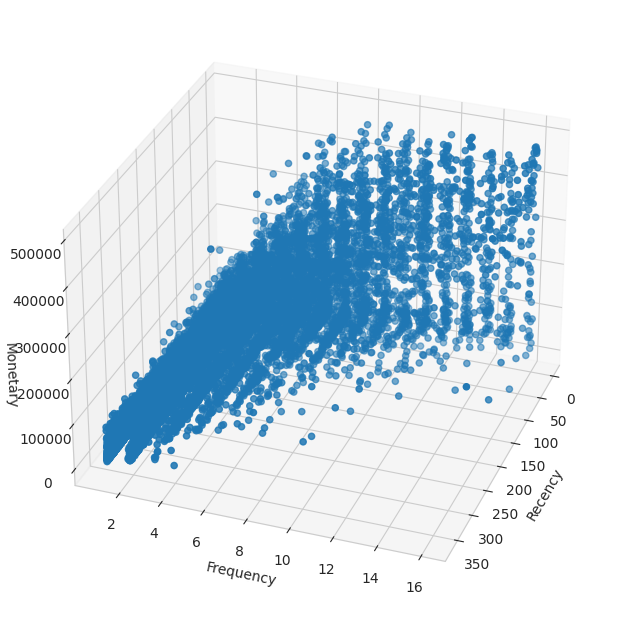

In [36]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(),
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');

По графику видно, что концентрация клиентов больше ближе к началу координат. По общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Давайте призовём на помощь методы снижения размерности.

### **Понижение размерности. Метод главных компонент.**

Начнём с метода главных компонент (*PCA*).

В **PCA** признаки преобразуются в новый набор переменных с меньшим (или таким же) количеством измерений, сохраняя при этом как можно больше вариаций, присутствующих в наборе данных. Геометрически это значит, что метод главных компонент ищет гиперплоскость заданной размерности, при проекции на которую сумма квадратов расстояний от исходных точек будет минимальной.

Нам известно, что для его стабильной работы данные необходимо стандартизировать/нормализовать.

Давайте для удобства обернём эти шаги по предобработке данных в *pipeline*.

Создадим pipeline, в котором будут следующие шаги:
* стандартизация с помощью *StandardScaler* с параметрами по умолчанию;
* метод главных компонент с двумя компонентами.

Обучим *pipeline* на *RFM*-таблице, очищенной от выбросов, и применим к ней трансформацию.

In [37]:
# создадим пайплайн со стандартизацией и уменьшением размерности
pca_pipe = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()), ('pca', decomposition.PCA(n_components=2))])
# обучим пайплайн, и сохраним новые главные компоненты
processed = pca_pipe.fit_transform(rfm_table_cleaned)
# сохраним данные в виде датафрейма
rfm_table_processed = pd.DataFrame(
    data = processed,
    columns= ['axis-1', 'axis-2']
)

# ответ
print('Первая главная компонента объясняет', round(pca_pipe['pca'].explained_variance_ratio_[0], 2), '% дисперсии')
print('Вторая главная компонента объясняет', round(pca_pipe['pca'].explained_variance_ratio_[1], 2), '% дисперсии')

Первая главная компонента объясняет 0.58 % дисперсии
Вторая главная компонента объясняет 0.24 % дисперсии


Визуализируем пространство главных компонент после декомпозиции:

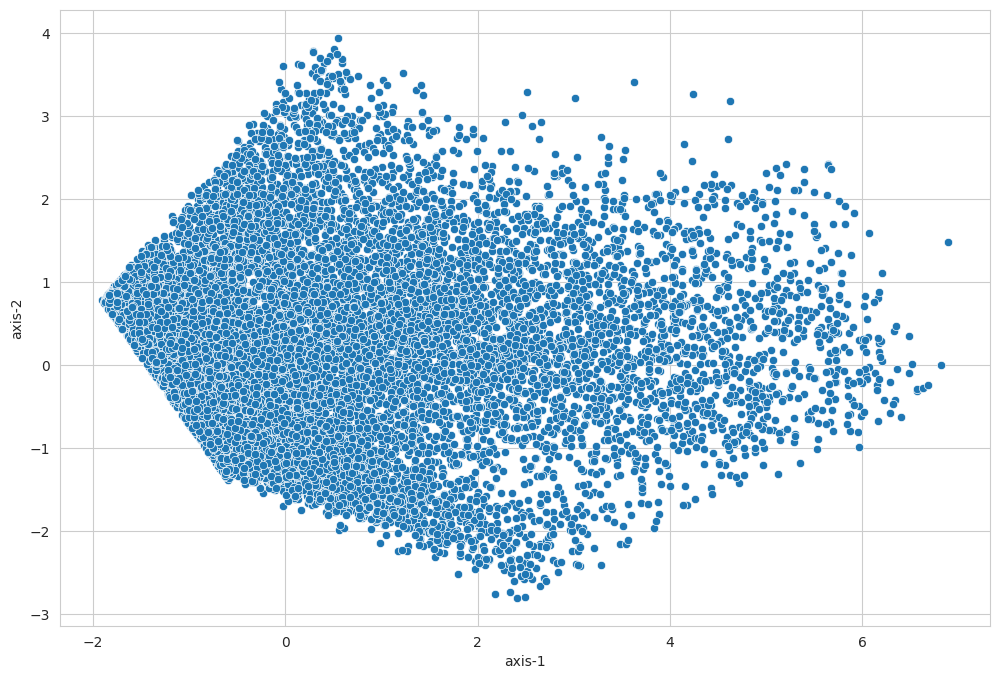

In [38]:
fig = plt.figure(figsize=(12, 8))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

#### **Первым делом воспользуемся методом кластеризации k-means.**

Идея алгоритма *k-means* состоит в том, что он итеративно разбивает множество объектов на заранее заданное пользователем число кластеров и стремится минимизировать расстояние от объектов внутри кластера до центроида кластера.

Подберем оптимальное количество кластеров для метода *k-means*. Для этого мы ипользуем внутренние меры оценки качества кластеризации: коэффициента силуэта, индекса Калински — Харабаса, и индекса Дэвиса — Болдина.

* **Коэффициент силуэта** показывает, насколько объект похож на объекты из своего собственного кластера по сравнению с объектами из других кластеров. Чем выше его значение, тем лучше.
* **Индекс Калински — Харабаса** показывает, насколько кластеры плотные и хорошо разделены. Чем выше его значение, тем лучше.
* **Индекс Дэвиса — Болдина** показывает среднюю «схожесть» между кластерами. Чем меньше значение (меньше похожи), тем лучше.

Будем перебирать возможные количества кластеров от 3 до 20 включительно.

Максимальное значение коэффициента силуэта даёт алгоритм KMeans: 0.46 на 7 клстерах
Максимальное значение индекса Калински — Харабаса даёт алгоритм KMeans: 24509.35 на 6 клстерах
Минимальное значение индекса Дэвиса — Болдина даёт алгоритм KMeans: 0.76 на 4 клстерах
Оптимальное количество кластеров для алгоритма KMeans составляет 6 кластеров


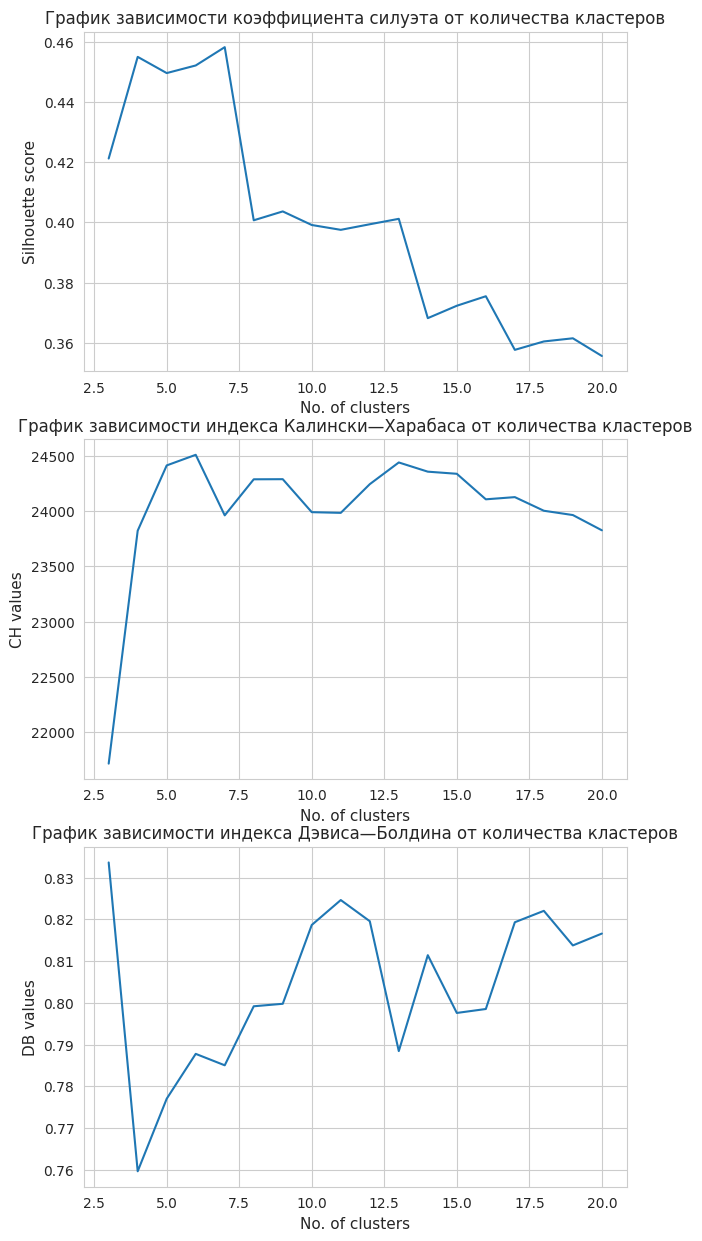

In [39]:
# инициализируем пустые списки для значений метрик
silhouette = []
ch_score = []
db_score = []

# зададим диапазон кластеризации
clut_range = range(3, 21)

for clust_num in clut_range:
  # определяем алгоритм кластеризации
  k_means =  cluster.KMeans(n_clusters=clust_num, random_state=42)
  # обучаем его на наших данных
  k_means.fit(rfm_table_processed)

  # подсчитаем метрику силуэта
  silhouette.append(metrics.silhouette_score(rfm_table_processed, k_means.labels_))
  # расчитаем индекс Калински—Харабаса
  ch_score.append(metrics.calinski_harabasz_score(rfm_table_processed, k_means.labels_))
  # расчитаем индекс Дэвиса—Болдина
  db_score.append(metrics.davies_bouldin_score(rfm_table_processed, k_means.labels_))

# визуализируем зависимости метрик от количества кластеров
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 15))

# визуализируем коэффициенты силуэта
sns.lineplot(x=[i for i in clut_range], y=silhouette, ax=axes[0])
axes[0].set_title('График зависимости коэффициента силуэта от количества кластеров', fontsize=12)
axes[0].set_xlabel("No. of clusters", fontsize=11)
axes[0].set_ylabel("Silhouette score", fontsize=11)
# визуализируем индекс Калински — Харабаса
sns.lineplot(x=[i for i in clut_range], y=ch_score, ax=axes[1])
axes[1].set_title('График зависимости индекса Калински—Харабаса от количества кластеров', fontsize=12)
axes[1].set_xlabel("No. of clusters", fontsize=11)
axes[1].set_ylabel("CH values", fontsize=11)
# визуализируем индекс Дэвиса — Болдина
sns.lineplot(x=[i for i in clut_range], y=db_score, ax=axes[2])
axes[2].set_title('График зависимости индекса Дэвиса—Болдина от количества кластеров', fontsize=12)
axes[2].set_xlabel("No. of clusters", fontsize=11)
axes[2].set_ylabel("DB values", fontsize=11);

print('Максимальное значение коэффициента силуэта даёт алгоритм KMeans:',
      round(max(silhouette), 2), 'на', silhouette.index(max(silhouette)) + 3, 'клстерах')
print('Максимальное значение индекса Калински — Харабаса даёт алгоритм KMeans:',
      round(max(ch_score), 2), 'на', ch_score.index(max(ch_score)) + 3, 'клстерах')
print('Минимальное значение индекса Дэвиса — Болдина даёт алгоритм KMeans:',
      round(min(db_score), 2), 'на', db_score.index(min(db_score)) + 3, 'клстерах')
print('Оптимальное количество кластеров для алгоритма KMeans составляет',
      round((silhouette.index(max(silhouette)) + ch_score.index(max(ch_score)) + db_score.index(min(db_score))) / 3) + 3,
      'кластеров')

По граффикам видно, что с увеличением числа кластеров, значения внутренних мер ухудшаются.

Если брать во внимание показатели всех внутренних мер, то оптимальное количество кластеров - 7.

#### **Теперь используем EM-алгоритм.**

**EM (Expectation-maximization)** — модель гауссовой смеси (*Gaussian Mixture Model, GMM*), в которой данные описываются законом нормального распределения.

Подберем оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью внутренних мер, перебирая возможные значения от 3 до 20 включительно.

Максимальное значение коэффициента силуэта даёт EM-алгоритм: 0.41 на 5 клстерах
Максимальное значение индекса Калински — Харабаса даёт EM-алгоритм: 20856.48 на 19 клстерах
Минимальное значение индекса Дэвиса — Болдина даёт EM-алгоритм: 0.85 на 19 клстерах
Оптимальное количество кластеров для EM-алгоритма составляет 14 кластеров


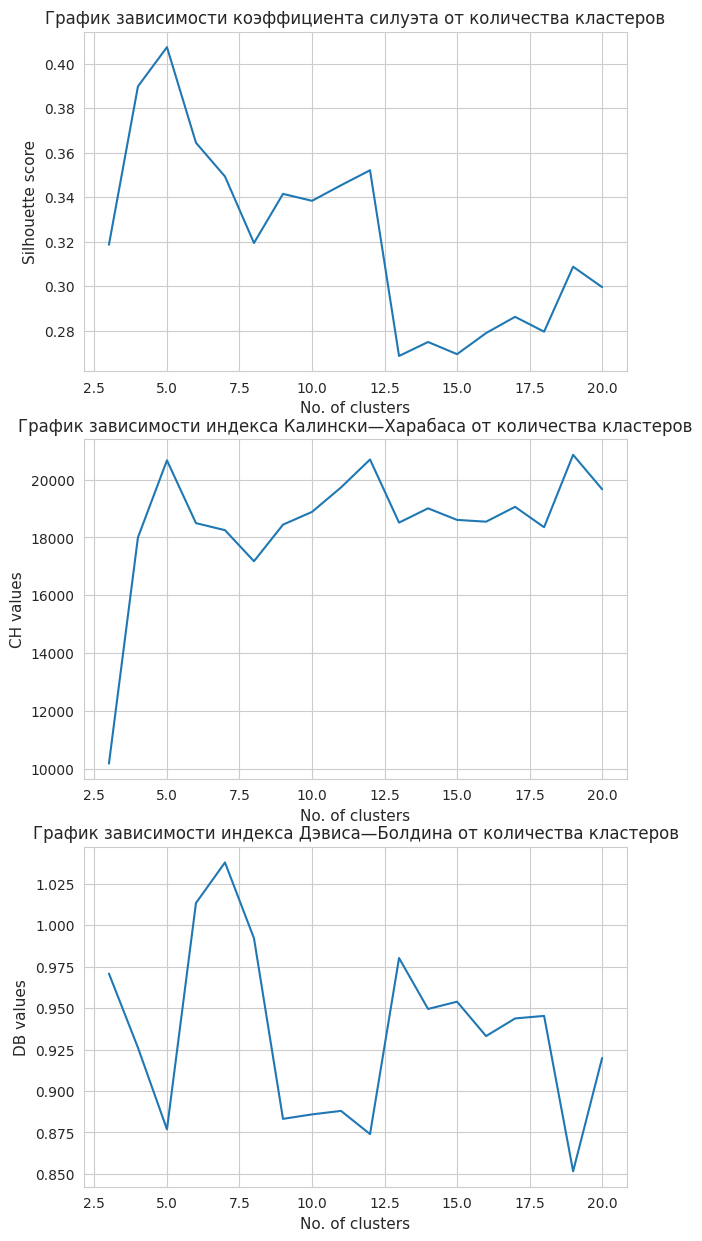

In [40]:
# инициализируем пустые списки для значений метрик
silhouette = []
ch_score = []
db_score = []

for clust_num in clut_range:
  # определяем алгоритм кластеризации
  gm = mixture.GaussianMixture(n_components=clust_num, random_state=42)
  # обучаем его на наших данных
  labels = gm.fit_predict(rfm_table_processed)

  # подсчитаем метрику силуэта
  silhouette.append(metrics.silhouette_score(rfm_table_processed, labels))
  # расчитаем индекс Калински—Харабаса
  ch_score.append(metrics.calinski_harabasz_score(rfm_table_processed, labels))
  # расчитаем индекс Дэвиса—Болдина
  db_score.append(metrics.davies_bouldin_score(rfm_table_processed, labels))

# визуализируем зависимости метрик от количества кластеров
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 15))

# визуализируем коэффициенты силуэта
sns.lineplot(x=[i for i in clut_range], y=silhouette, ax=axes[0])
axes[0].set_title('График зависимости коэффициента силуэта от количества кластеров', fontsize=12)
axes[0].set_xlabel("No. of clusters", fontsize=11)
axes[0].set_ylabel("Silhouette score", fontsize=11)
# визуализируем индекс Калински — Харабаса
sns.lineplot(x=[i for i in clut_range], y=ch_score, ax=axes[1])
axes[1].set_title('График зависимости индекса Калински—Харабаса от количества кластеров', fontsize=12)
axes[1].set_xlabel("No. of clusters", fontsize=11)
axes[1].set_ylabel("CH values", fontsize=11)
# визуализируем индекс Дэвиса — Болдина
sns.lineplot(x=[i for i in clut_range], y=db_score, ax=axes[2])
axes[2].set_title('График зависимости индекса Дэвиса—Болдина от количества кластеров', fontsize=12)
axes[2].set_xlabel("No. of clusters", fontsize=11)
axes[2].set_ylabel("DB values", fontsize=11);

print('Максимальное значение коэффициента силуэта даёт EM-алгоритм:',
      round(max(silhouette), 2), 'на', silhouette.index(max(silhouette)) + 3, 'клстерах')
print('Максимальное значение индекса Калински — Харабаса даёт EM-алгоритм:',
      round(max(ch_score), 2), 'на', ch_score.index(max(ch_score)) + 3, 'клстерах')
print('Минимальное значение индекса Дэвиса — Болдина даёт EM-алгоритм:',
      round(min(db_score), 2), 'на', db_score.index(min(db_score)) + 3, 'клстерах')
print('Оптимальное количество кластеров для EM-алгоритма составляет',
      round((silhouette.index(max(silhouette)) + ch_score.index(max(ch_score)) + db_score.index(min(db_score))) / 3) + 3,
      'кластеров')

По граффикам видно, что с увеличением числа кластеров, значения внутренних мер ухудшаются.

По значениям внутренних мер оптимальное количество кластеров - 5.

У модели *k-means* значения внутренних мер лучше. Поэтому на её базе произведем кластеризацию, и посмотрим на распределении кластеров в двумерном пространстве главных компонент.

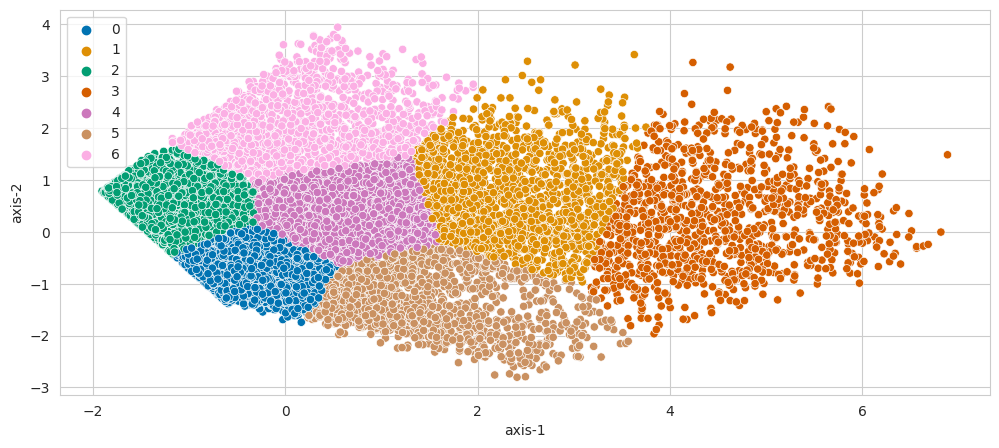

In [41]:
# зададим число кластеров
cnt_clusters = 7
# инициализируем алгоритм кластеризации
k_means = cluster.KMeans(n_clusters=cnt_clusters, random_state=42)
# обучим алгоритм на декомпозированных данных
k_means.fit(rfm_table_processed)
# запишем номера кластеров
labels = k_means.labels_


fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    hue=labels,
    palette='colorblind'
);

#### **Профили кластеров по *k-means*.**

Итак, у нас есть 7 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов.

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов.  Сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков.

In [42]:
# добавим в frm-таблицу признак кластера
rfm_table_cleaned['labels'] = labels
# сгруппируем данные по кластерам, и рассчитаем среднее по признакам
grouped_rfm = rfm_table_cleaned.groupby('labels').mean().round()
rfm_table_cleaned.drop(['labels'], axis=1, inplace=True)
grouped_rfm.astype(int)

Recency  Frequency  Monetary  Quantity
labels                                        
0            76          2     13187        10
1            63          5    177730        72
2           257          1      8817        11
3            40         10    334738        66
4            97          3     66664        51
5            37          8     67635        16
6           251          1     54875        75

Для визуализации профилей мы используем полярную диаграмму. Это графическое представление значений нескольких эквивалентных категорий в форме «паутины». На концах «паутины» откладываются оси, которые соответствуют признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник.

In [43]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()
    
plot_cluster_profile(grouped_rfm, cnt_clusters)

### **Понижение размерности. t-SNE.**

PCA является линейным методом отображения исходного пространства признаков в его сжатую версию. Этот метод дал нам всего 7 кластеров. А нам нужно гораздо больше, так как нам нужны вариации сочетаний не 3-х признаков RFM, а 4-х RFMQ.

А что если использовать нелинейную трансформацию? Например, алгоритм снижения размерности t-SNE.

**t-SNE (стохастическое вложение соседей с t-распределением)**. Его преимущество относительно *PCA* заключается в том, что он может реализовывать уменьшение размерности и разделение для данных, которые являются линейно неразделимыми.

Воспользуемся алгоритмом *t-SNE* и трансформируем *RFM*-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Давайте для удобства обернём шаги по предобработке данных в *pipeline*.

Создадим *pipeline*, который будет содержать следующие шаги:
* стандартизация с помощью *StandardScaler* с параметрами по умолчанию;
* алгоритм *t-SNE* с двумя компонентами.

Обучим *pipeline* на *RFM*-таблице (очищенной от выбросов), полученной ранее, и применим к ней трансформацию. И визуализируем пространство после декомпозиции с помощью *t-SNE*.

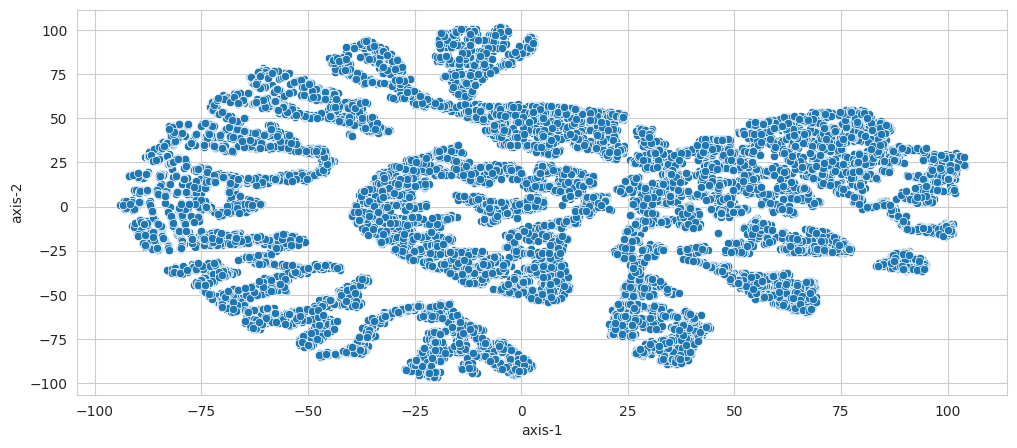

In [44]:
# создадим пайплайн со стандартизацией и уменьшением размерности
tsne_pipe = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()),
                               ('tsne', manifold.TSNE(n_components=2, perplexity=50, random_state=42))
                               ])
# обучим пайплайн, и сохраним
processed = tsne_pipe.fit_transform(rfm_table_cleaned)
# сохраним данные в виде датафрейма
rfm_table_processed_tsne = pd.DataFrame(
    data = processed,
    columns= ['axis-1', 'axis-2']
)

fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed_tsne, x='axis-1', y='axis-2');

Как и ожидалось от *t-SNE*, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров.

Теперь давайте воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.

#### **Кластеризация k-means.**

Так как у наших клиентов имеется 4 признака, то и количество возможных кластеров может возрасти в геометрической прогрессии. Если брать по две подгруппы клиентов в каждом признаке, мы получим 16 комбинаций. А если по 3 подгруппы клиентов - 80. Учитывая, что распределения признаков не равномерные, возьмем для тестирования количество кластеров до 40.

Будем перебирать возможные количества кластеров от 3 до 40 включительно.

Максимальное значение коэффициента силуэта даёт алгоритм KMeans: 0.42 на 32 клстерах
Максимальное значение индекса Калински — Харабаса даёт алгоритм KMeans: 30710.66 на 40 клстерах
Минимальное значение индекса Дэвиса — Болдина даёт алгоритм KMeans: 0.74 на 12 клстерах
Оптимальное количество кластеров для алгоритма KMeans составляет 28 кластеров


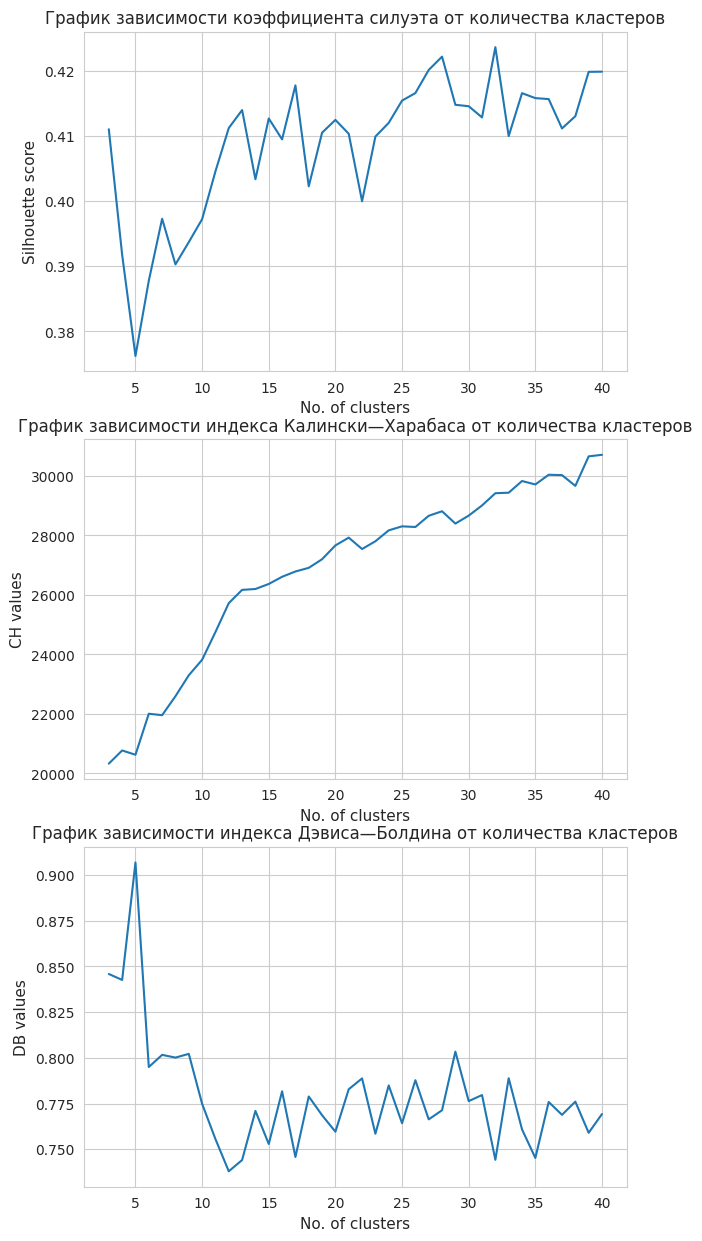

In [45]:
# инициализируем пустые списки для значений метрик
silhouette = []
ch_score = []
db_score = []

clut_range = range(3, 41)

for clust_num in clut_range:
  # определяем алгоритм кластеризации
  k_means =  cluster.KMeans(n_clusters=clust_num, random_state=42)
  # обучаем его на наших данных
  k_means.fit(rfm_table_processed_tsne)

  # подсчитаем метрику силуэта
  silhouette.append(metrics.silhouette_score(rfm_table_processed_tsne, k_means.labels_))
  # расчитаем индекс Калински—Харабаса
  ch_score.append(metrics.calinski_harabasz_score(rfm_table_processed_tsne, k_means.labels_))
  # расчитаем индекс Дэвиса—Болдина
  db_score.append(metrics.davies_bouldin_score(rfm_table_processed_tsne, k_means.labels_))

# визуализируем зависимости метрик от количества кластеров
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 15))

# визуализируем коэффициенты силуэта
sns.lineplot(x=[i for i in clut_range], y=silhouette, ax=axes[0])
axes[0].set_title('График зависимости коэффициента силуэта от количества кластеров', fontsize=12)
axes[0].set_xlabel("No. of clusters", fontsize=11)
axes[0].set_ylabel("Silhouette score", fontsize=11)
# визуализируем индекс Калински — Харабаса
sns.lineplot(x=[i for i in clut_range], y=ch_score, ax=axes[1])
axes[1].set_title('График зависимости индекса Калински—Харабаса от количества кластеров', fontsize=12)
axes[1].set_xlabel("No. of clusters", fontsize=11)
axes[1].set_ylabel("CH values", fontsize=11)
# визуализируем индекс Дэвиса — Болдина
sns.lineplot(x=[i for i in clut_range], y=db_score, ax=axes[2])
axes[2].set_title('График зависимости индекса Дэвиса—Болдина от количества кластеров', fontsize=12)
axes[2].set_xlabel("No. of clusters", fontsize=11)
axes[2].set_ylabel("DB values", fontsize=11);

print('Максимальное значение коэффициента силуэта даёт алгоритм KMeans:',
      round(max(silhouette), 2), 'на', silhouette.index(max(silhouette)) + 3, 'клстерах')
print('Максимальное значение индекса Калински — Харабаса даёт алгоритм KMeans:',
      round(max(ch_score), 2), 'на', ch_score.index(max(ch_score)) + 3, 'клстерах')
print('Минимальное значение индекса Дэвиса — Болдина даёт алгоритм KMeans:',
      round(min(db_score), 2), 'на', db_score.index(min(db_score)) + 3, 'клстерах')
print('Оптимальное количество кластеров для алгоритма KMeans составляет',
      round((silhouette.index(max(silhouette)) + ch_score.index(max(ch_score)) + db_score.index(min(db_score))) / 3) + 3,
      'кластеров')

По граффикам видно, что с увеличением числа кластеров, значения внутренних мер не значительно улучшаются.

По значениям внутренних мер оптимальное количество кластеров - 28, 32.

#### **EM-алгоритм кластеризации.**

Подберем оптимальное количество кластеров для *EM*-алгоритма (**GaussianMixture**) с помощью коэффициента силуэта, перебирая возможные значения от 3 до 40 включительно.

Максимальное значение коэффициента силуэта даёт EM-алгоритм: 0.41 на 3 клстерах
Максимальное значение индекса Калински — Харабаса даёт EM-алгоритм: 26132.43 на 40 клстерах
Минимальное значение индекса Дэвиса — Болдина даёт EM-алгоритм: 0.74 на 12 клстерах
Оптимальное количество кластеров для алгоритма KMeans составляет 18 кластеров


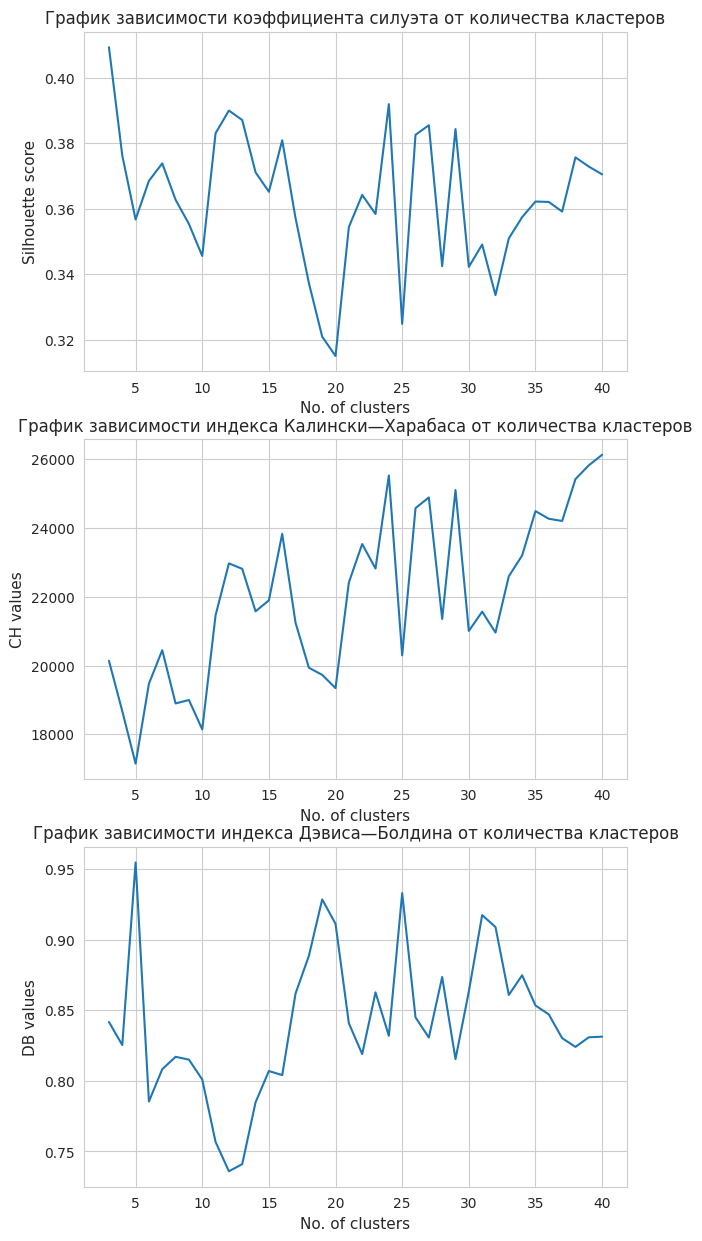

In [46]:
# инициализируем пустые списки для значений метрик
silhouette = []
ch_score = []
db_score = []

for clust_num in clut_range:
  # определяем алгоритм кластеризации
  gm = mixture.GaussianMixture(n_components=clust_num, random_state=42)
  # обучаем его на наших данных
  labels = gm.fit_predict(rfm_table_processed_tsne)

  # подсчитаем метрику силуэта
  silhouette.append(metrics.silhouette_score(rfm_table_processed_tsne, labels))
  # расчитаем индекс Калински—Харабаса
  ch_score.append(metrics.calinski_harabasz_score(rfm_table_processed_tsne, labels))
  # расчитаем индекс Дэвиса—Болдина
  db_score.append(metrics.davies_bouldin_score(rfm_table_processed_tsne, labels))

# визуализируем зависимости метрик от количества кластеров
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 15))

# визуализируем коэффициенты силуэта
sns.lineplot(x=[i for i in clut_range], y=silhouette, ax=axes[0])
axes[0].set_title('График зависимости коэффициента силуэта от количества кластеров', fontsize=12)
axes[0].set_xlabel("No. of clusters", fontsize=11)
axes[0].set_ylabel("Silhouette score", fontsize=11)
# визуализируем индекс Калински — Харабаса
sns.lineplot(x=[i for i in clut_range], y=ch_score, ax=axes[1])
axes[1].set_title('График зависимости индекса Калински—Харабаса от количества кластеров', fontsize=12)
axes[1].set_xlabel("No. of clusters", fontsize=11)
axes[1].set_ylabel("CH values", fontsize=11)
# визуализируем индекс Дэвиса — Болдина
sns.lineplot(x=[i for i in clut_range], y=db_score, ax=axes[2])
axes[2].set_title('График зависимости индекса Дэвиса—Болдина от количества кластеров', fontsize=12)
axes[2].set_xlabel("No. of clusters", fontsize=11)
axes[2].set_ylabel("DB values", fontsize=11);

print('Максимальное значение коэффициента силуэта даёт EM-алгоритм:',
      round(max(silhouette), 2), 'на', silhouette.index(max(silhouette)) + 3, 'клстерах')
print('Максимальное значение индекса Калински — Харабаса даёт EM-алгоритм:',
      round(max(ch_score), 2), 'на', ch_score.index(max(ch_score)) + 3, 'клстерах')
print('Минимальное значение индекса Дэвиса — Болдина даёт EM-алгоритм:',
      round(min(db_score), 2), 'на', db_score.index(min(db_score)) + 3, 'клстерах')
print('Оптимальное количество кластеров для алгоритма KMeans составляет',
      round((silhouette.index(max(silhouette)) + ch_score.index(max(ch_score)) + db_score.index(min(db_score))) / 3) + 3,
      'кластеров')

По граффикам видно, что с увеличением числа кластеров, значения внутренних мер колебаются. И значения хуже, чем у *K-Means*.

К сожалению, *EM*-алгоритм не дал лучших результатов.

#### **Aлгоритмом алгомеративной кластеризации AgglomerativeClustering.**

При агломеративном алгоритме кластеризации каждый объект является отдельным кластером, на каждом шаге соединяем два самых близких кластера, и останавливаемся, когда получаем требуемое количество кластеров или единственный кластер.

Этот алгоритм работает в 2.5 разa дольше, чем от же K-Means. Поэтому уменьшим диапазон, и подберём оптимальное количество кластеров, перебирая возможные значения от 20 до 40 включительно. 

Максимальное значение коэффициента силуэта даёт алгоритм алгомеративной кластеризации: 0.38 на 40 клстерах
Максимальное значение индекса Калински — Харабаса даёт алгоритм алгомеративной кластеризации: 27244.56 на 40 клстерах
Минимальное значение индекса Дэвиса — Болдина даёт алгоритм алгомеративной кластеризации: 0.78 на 35 клстерах
Оптимальное количество кластеров для алгоритма алгомеративной кластеризации составляет 38 кластеров


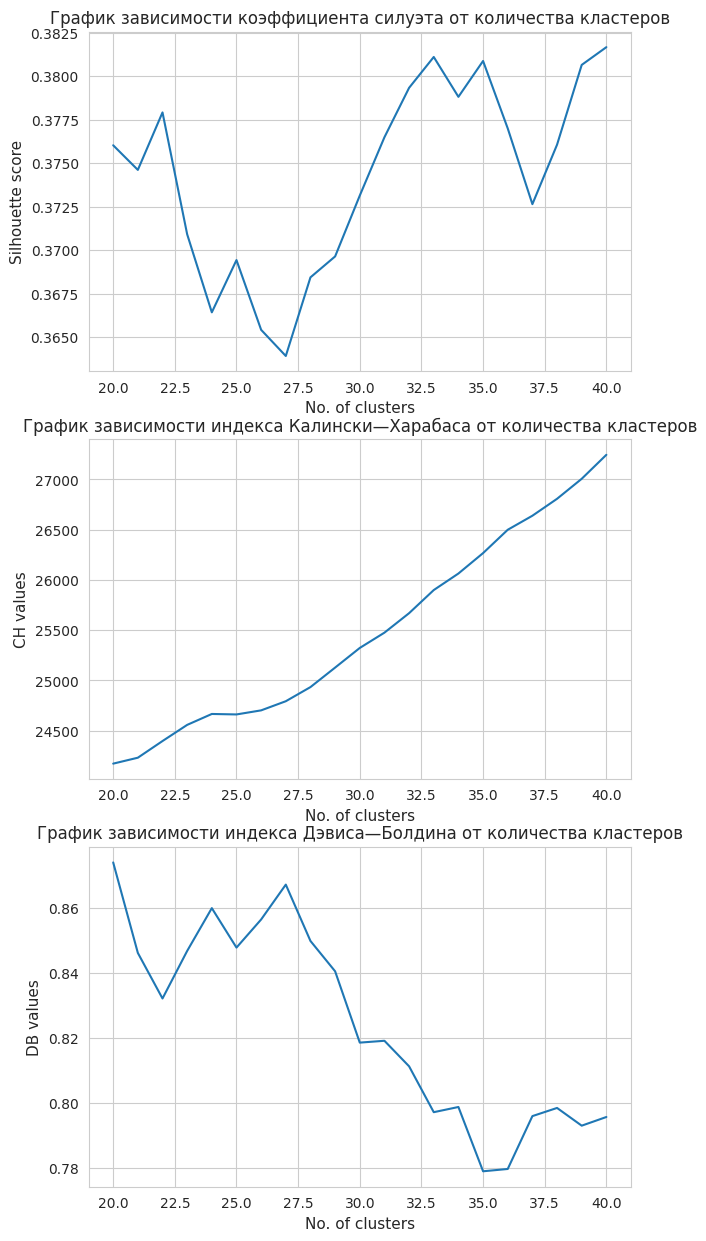

In [47]:
clut_range = range(20, 41)

# инициализируем пустые списки для значений метрик
silhouette = []
ch_score = []
db_score = []

for clust_num in clut_range:
  # определяем алгоритм кластеризации
  ac = cluster.AgglomerativeClustering(n_clusters=clust_num)
  # обучаем его на наших данных
  ac.fit(rfm_table_processed_tsne)

  # подсчитаем метрику силуэта
  silhouette.append(metrics.silhouette_score(rfm_table_processed_tsne, ac.labels_))
  # расчитаем индекс Калински—Харабаса
  ch_score.append(metrics.calinski_harabasz_score(rfm_table_processed_tsne, ac.labels_))
  # расчитаем индекс Дэвиса—Болдина
  db_score.append(metrics.davies_bouldin_score(rfm_table_processed_tsne, ac.labels_))

# визуализируем зависимости метрик от количества кластеров
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 15))

# визуализируем коэффициенты силуэта
sns.lineplot(x=[i for i in clut_range], y=silhouette, ax=axes[0])
axes[0].set_title('График зависимости коэффициента силуэта от количества кластеров', fontsize=12)
axes[0].set_xlabel("No. of clusters", fontsize=11)
axes[0].set_ylabel("Silhouette score", fontsize=11)
# визуализируем индекс Калински — Харабаса
sns.lineplot(x=[i for i in clut_range], y=ch_score, ax=axes[1])
axes[1].set_title('График зависимости индекса Калински—Харабаса от количества кластеров', fontsize=12)
axes[1].set_xlabel("No. of clusters", fontsize=11)
axes[1].set_ylabel("CH values", fontsize=11)
# визуализируем индекс Дэвиса — Болдина
sns.lineplot(x=[i for i in clut_range], y=db_score, ax=axes[2])
axes[2].set_title('График зависимости индекса Дэвиса—Болдина от количества кластеров', fontsize=12)
axes[2].set_xlabel("No. of clusters", fontsize=11)
axes[2].set_ylabel("DB values", fontsize=11);

print('Максимальное значение коэффициента силуэта даёт алгоритм алгомеративной кластеризации:',
      round(max(silhouette), 2), 'на', silhouette.index(max(silhouette)) + 20, 'клстерах')
print('Максимальное значение индекса Калински — Харабаса даёт алгоритм алгомеративной кластеризации:',
      round(max(ch_score), 2), 'на', ch_score.index(max(ch_score)) + 20, 'клстерах')
print('Минимальное значение индекса Дэвиса — Болдина даёт алгоритм алгомеративной кластеризации:',
      round(min(db_score), 2), 'на', db_score.index(min(db_score)) + 20, 'клстерах')
print('Оптимальное количество кластеров для алгоритма алгомеративной кластеризации составляет',
      round((silhouette.index(max(silhouette)) + ch_score.index(max(ch_score)) + db_score.index(min(db_score))) / 3) + 20,
      'кластеров')

По граффикам видно, что с увеличением числа кластеров, значения внутренних мер улучшаются. Но значения гораздо хуже, чем у *K-Means*.

Увы, алгоритм агломеративной кластеризации не дал лучших результатов.

### **Применим k-means кластеризацию.**

У модели *k-means* значения внутренних мер лучше. Поэтому на её базе произведем кластеризацию, и посмотрим на распределении кластеров в двумерном пространстве главных компонент.

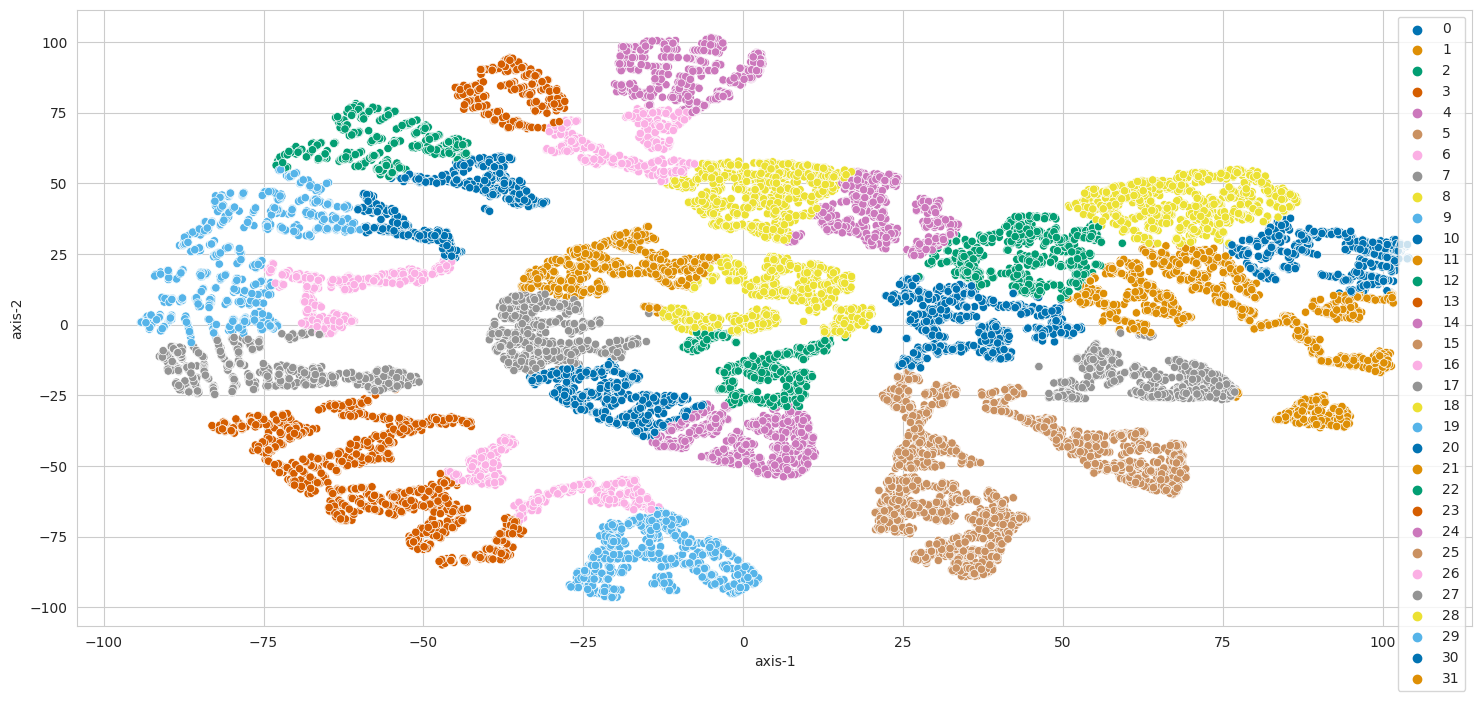

In [48]:
# зададим число кластеров
cnt_clusters = 32

# инициализируем алгоритм кластеризации
k_means = cluster.KMeans(n_clusters=cnt_clusters, random_state=37)
# обучим алгоритм на декомпозированных данных
k_means.fit(rfm_table_processed_tsne)
# запишем номера кластеров
labels = k_means.labels_


fig = plt.figure(figsize=(18, 8))
sns.scatterplot(
    data=rfm_table_processed_tsne, 
    x='axis-1', 
    y='axis-2', 
    hue=labels,
    palette='colorblind'
);

#### **Профили кластеров по *k-means*.**

Итак, у нас есть 32 сегмента клиентов. Давайте попробуем составить профиль для этих сегментов.

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов.  Сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков.

In [49]:
# добавим в frm-таблицу признак кластера
rfm_table_cleaned['labels'] = labels
# сгруппируем данные по кластерам, и рассчитаем среднее по признакам
grouped_rfm = rfm_table_cleaned.groupby('labels').mean().round()
rfm_table_cleaned.drop(['labels'], axis=1, inplace=True)
grouped_rfm.astype(int)

Recency  Frequency  Monetary  Quantity
labels                                        
0           269          1     10763        18
1            50          6    163589        48
2            53          2     37644        36
3            74          1      4840         6
4           346          1      4359         6
5            55          3     22550        12
6           326          1     11979        21
7           169          1      6534        10
8            43         10    348435        70
9            24          1      5316         8
10          108          2     11432         8
11           46          8     49674        10
12           59          4    185016        86
13          311          1      4414         6
14           34          2     11535         9
15           59          4     28564        12
16          213          1     10309        17
17           97          5     50465        16
18          135          2     58519        63
19          207          1      4228         6
20           40         12    144152        24
21           37          6     36970        10
22          282          1      4402         6
23          125          1      6135        10
24          170          1     71189       102
25          206          3     24300        12
26           55          1     12114        21
27          191          2     13306        11
28          263          1     34194        61
29          245          1      4467         6
30          115          3    100462        53
31          280          2     16797        14

Для визуализации профилей мы используем полярную диаграмму. Это графическое представление значений нескольких эквивалентных категорий в форме «паутины». На концах «паутины» откладываются оси, которые соответствуют признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник.

In [50]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()
    
plot_cluster_profile(grouped_rfm, cnt_clusters)

Отлично! Мы получили монго кластеров, такое количество должно удовлетворить большинство потребностей маркетологов. В крайнем случае всегда можно учитывать дополнительную фильтрацию по *RFM*-признакам.

Теперь нужно понять, какие кластеры у нас получились.

## **6. Исследование полученных кластеров**

Учитывая значения полученных кластеров, специфику, и рекомендации маркетологов компании получилось создать следующую таюлицу.

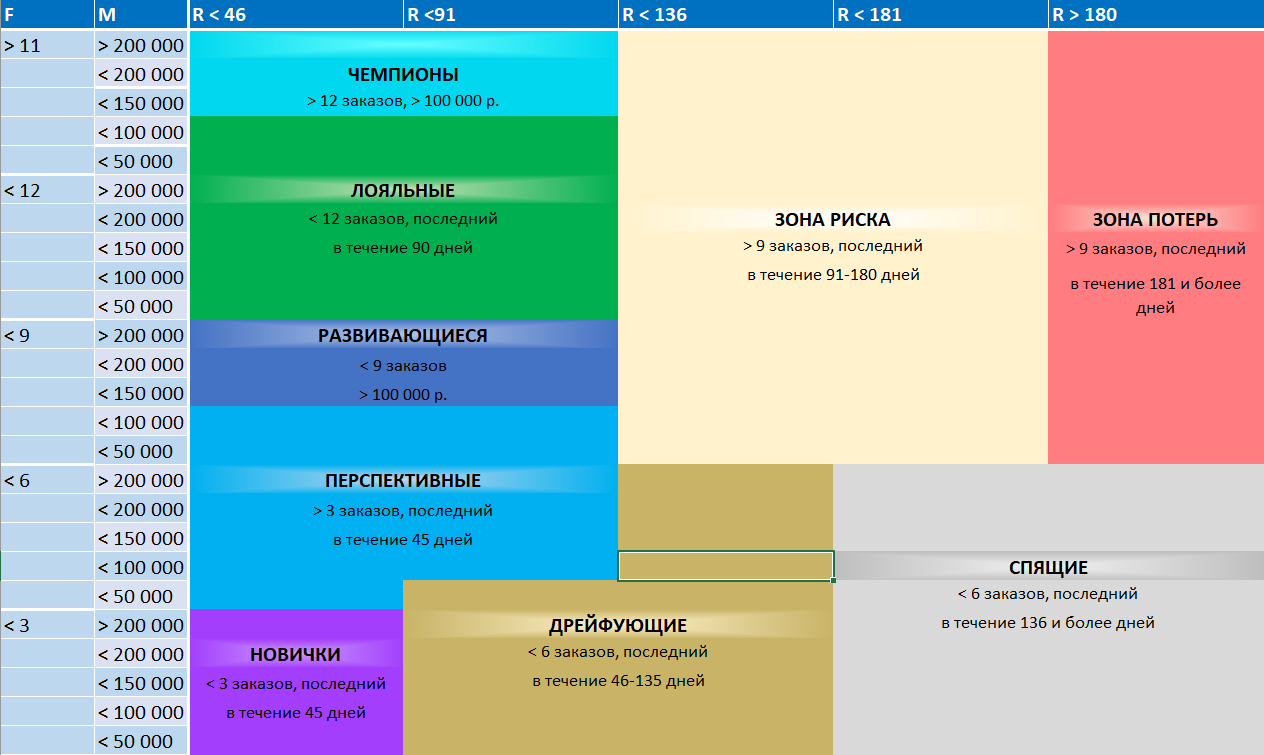 

Давайте охарактеризуем полученные кластеры в интерпретации этой таблицы. А так же определим уровни оптовой торговли.

Добавим следующие признаки:

* **wholesale** - обозначает уровень опта
* **state** - состояние клиента, в рамках *RFM*-таблицы

Примем, что *крупный оптовик* покупает в среднем больше 30 штук товаров в одном заказе. А просто *оптовик* от 10 до 30 штук.

In [51]:
# определим функцию классификации уровня опта по количеству товаров в заказе
def get_wholesale(quantity):    
    if quantity > 30:
        return 'Крупный оптовик'
    elif quantity > 10:
        return 'Оптовик'
    else:
        return 'Розничный'

# определим функцию классификации RFM-сегментов согласно таблице выше
def get_state(features):
    # F >= 12
    if (features['Frequency'] >= 12) & (features['Monetary'] >= 100000) & (features['Recency'] <= 90):
        return 'ЧЕМПИОНЫ'
    # F >= 9
    elif (features['Frequency'] >= 9) & (features['Recency'] <= 90):        
        return 'ЛОЯЛЬНЫЙ'
    # F >= 6
    elif features['Frequency'] >= 6:
        if (features['Monetary'] >= 100000) & (features['Recency'] <= 90):
            return 'РАЗВИВАЮЩИЕСЯ'
        elif features['Recency'] > 180:
            return 'ЗОНА ПОТЕРЬ'
        elif features['Recency'] > 135:
            return 'ЗОНА РИСКА'
        else:
            return 'ПЕРСПЕКТИВНЫЙ'
    # F >= 3
    elif features['Frequency'] >= 3:
        if ((features['Recency'] <= 90) & (features['Monetary'] >= 50000)) | (features['Recency'] <= 45):
            return 'ПЕРСПЕКТИВНЫЙ'
        elif features['Recency'] > 135:
            return 'СПЯЩИЙ'
        else:
            return 'ДРЕЙФУЮЩИЙ'
    else:
        if features['Recency'] > 135:
            return 'СПЯЩИЙ'
        elif features['Recency'] > 45:
            return 'ДРЕЙФУЮЩИЙ'
        else:
            return 'НОВИЧОК'
        
    return np.nan

# скопируем таблицу кластеров для дальнейшего анализа
clusters_df = grouped_rfm.copy()
clusters_df = clusters_df.astype(int)

clusters_df['wholesale'] = clusters_df['Quantity'].apply(get_wholesale)
clusters_df['state'] = clusters_df.apply(get_state, axis=1)

clusters_df.head()

Recency  Frequency  Monetary  Quantity        wholesale          state
labels                                                                        
0           269          1     10763        18          Оптовик         СПЯЩИЙ
1            50          6    163589        48  Крупный оптовик  РАЗВИВАЮЩИЕСЯ
2            53          2     37644        36  Крупный оптовик     ДРЕЙФУЮЩИЙ
3            74          1      4840         6        Розничный     ДРЕЙФУЮЩИЙ
4           346          1      4359         6        Розничный         СПЯЩИЙ

Посмотрим на распределения получившихся признаков.

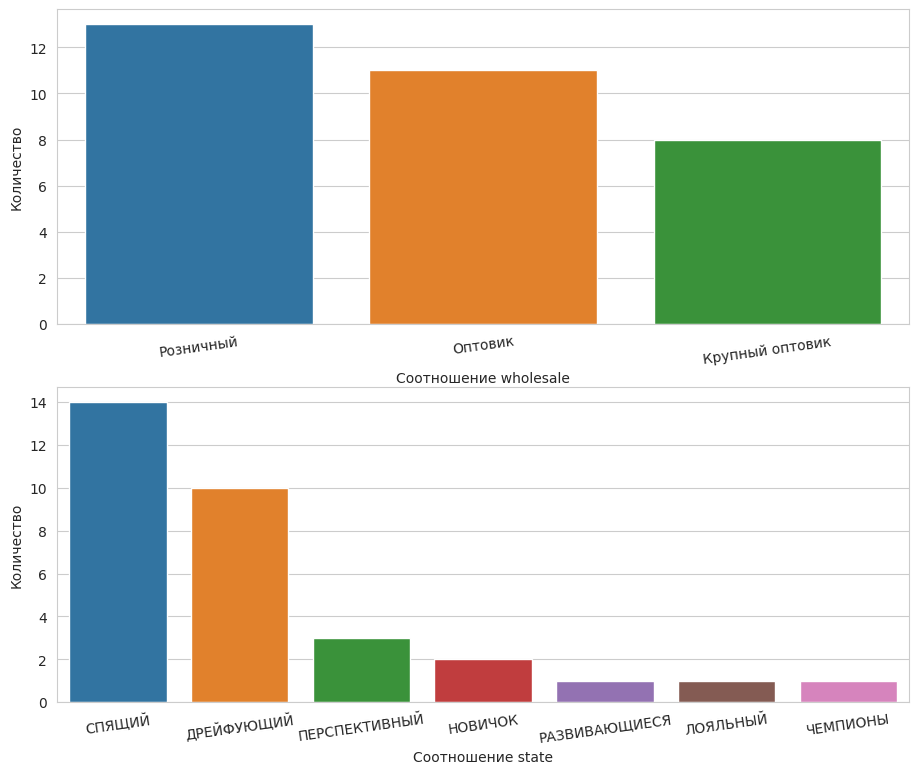

In [52]:
features = ['wholesale', 'state'] # признаки для распределений
n = len(features) #число категориальных признаков

fig, axes = plt.subplots(n, 1, figsize=(11, 9))
for i, feature in enumerate(features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = ((clusters_df[feature].value_counts())
                  .sort_values(ascending=False)
                  .rename('Количество')
                  .reset_index())
    percent_barplot = sns.barplot(data=count_data, x='index', y='Количество', ax=axes[i])
    percent_barplot.set_xlabel('Соотношение ' + feature);
    percent_barplot.xaxis.set_tick_params(rotation=8)

По диаграмме водно, что категорий оптовой торговли в полтора раза больше, чем розничной. И очень много кластеров: *СПЯЩИЙ*, *ДРЕЙФУЮЩИЙ*. Так же есть несколько кластеров, на которых можно настроить различные инструменты маркетинговой компании: *ПЕРСПЕКТИВНЫЙ*, *РАЗВИВАЮЩИЙСЯ*.

Посмотрим на распределение кластеров по уровню оптовой торговли и *RFM*-сегментам

In [53]:
# создадим временный признак 'index'
clusters_df['index'] = clusters_df.index

# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
pivot = clusters_df.pivot_table(
    values='index',
    index='state',
    columns='wholesale',
    aggfunc='count',
    fill_value=0
)

# удалим временный признак 'index'
clusters_df.drop(['index'],axis = 1, inplace=True)

pivot

wholesale      Крупный оптовик  Оптовик  Розничный
state                                             
ДРЕЙФУЮЩИЙ                   3        4          3
ЛОЯЛЬНЫЙ                     1        0          0
НОВИЧОК                      0        0          2
ПЕРСПЕКТИВНЫЙ                1        0          2
РАЗВИВАЮЩИЕСЯ                1        0          0
СПЯЩИЙ                       2        6          6
ЧЕМПИОНЫ                     0        1          0

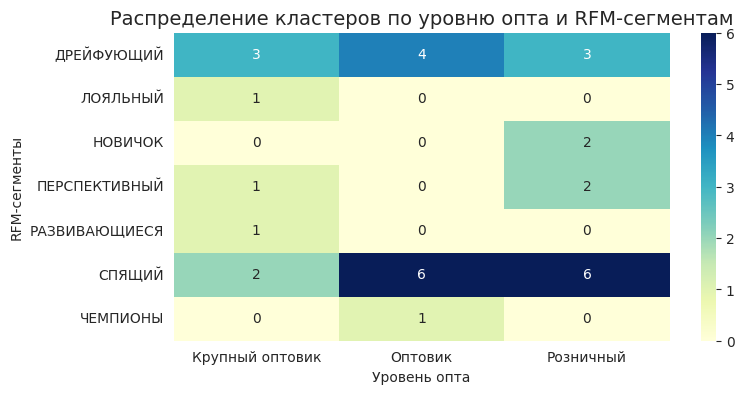

In [54]:
# построим тепловую карту
fig = plt.figure(figsize=(8, 4))
heatmap = sns.heatmap(data=pivot, annot=True, fmt ='.0f', cmap='YlGnBu');

heatmap.set_title('Распределение кластеров по уровню опта и RFM-сегментам', fontsize=14);
heatmap.set_xlabel('Уровень опта');
heatmap.set_ylabel('RFM-сегменты');

В целом, получилось много повторяющих ся кластеров. Если маркетологам не нужно будет такое разнообразие, то можно будет объединить повторяющиеся в один кластер определенного типа.

## **7. Классификация новых данных.**

**Следующая задача:** сделать предсказание сегмента для клиентов, которые не попали в обучающую выборку. Это новые клиенты, или отфильрованные выбросы при формировании RFM-таблицы для кластеризации. В конце концов, покупки в интернет-магазине совершают каждый день, и информация о клиентах будет меняться так-же. И чтобы оперативно обновлять информацию, необходимо сразу после подтверждения получения заказа покупателем определять актуальный кластер клиента.

Давайте сведём задачу кластеризации к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Давайте обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент.

### **Подготовка к классификации.**

Первым делом посмотрим на корреляцию между признаками.

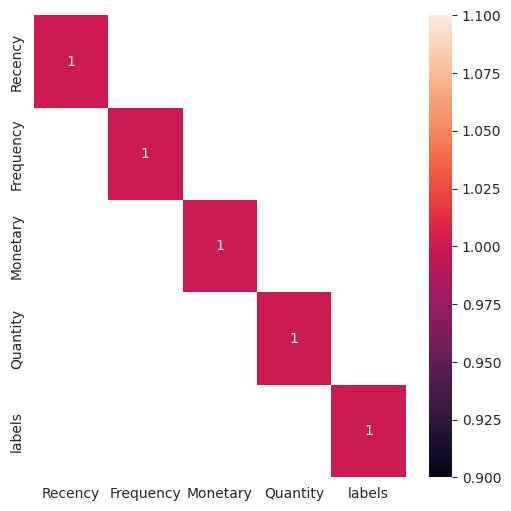

In [55]:
# добавим в таблицу признак с кластерами
rfm_table_cleaned['labels'] = labels

#  оценим данные на предмет наличия мультиколлинеарности
corr = rfm_table_cleaned.corr()
corr_over08= corr[np.abs(corr) >= 0.8]

fig = plt.figure(figsize=(6,6))
sns.heatmap(corr_over08, annot=True);

Очевидно, что мультиколлениарность отсутствует.

Посмотрим на корреляцию признаков с целевой переменной.

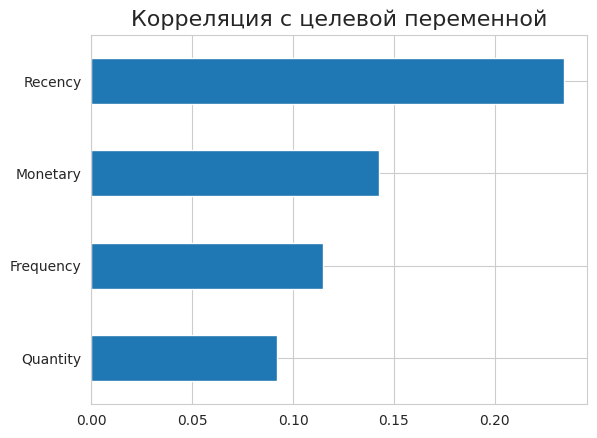

In [56]:
corr["labels"].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()
plt.title("Корреляция с целевой переменной", fontsize = 16)
plt.show()

По гафику видно, что целевая переменная практически не зависит от каждого в отдельности признака.

Pазделим исходные данные на тренировочную и тестовую выборки в соотношении 80/20.

In [57]:
# cоздаём матрицу наблюдений X и вектор правильных ответов y
X = rfm_table_cleaned.drop(['labels'], axis=1) # очищенная RFM-таблица
y = rfm_table_cleaned['labels']# метки кластеров, предсказанные ранее
# разделим исходные данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=37
)

print('В тестовую выборку попали', X_test.shape[0], 'клиентов')

В тестовую выборку попали 4469 клиентов


Данные для обучения представлены в различных единицах измерения, в разном масштабе. Признаки, которые измеряются в разных масштабах, в разной степени влияют на предсказание модели. Для решения этой проблемы перед обучением обычно делают нормализацию признаков.

Hормализуем данные с помощью *MinMaxScaler*.

При применении нормализации методом *MinMaxScaler* все значения признаков будут преобразованы в диапазон [0,1], что означает, что минимальное и максимальное значение признака будет равно 0 и 1 соответственно.

In [58]:
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# Копируем названия столбцов, которые теряются при использовании fit_transform()
col_names = list(X_train.columns)

# копируем исходный датасет
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.fit_transform(X_test)

# Преобразуем промежуточный датасет в полноценный датафрейм
X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_names)

Дальше нам осталось только построить несколько моделей и выбрать из них лучшую. 
Мы знаем, что алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут.

Поэтому давайте сразу возьмём тяжелую артиллерию — ансамблевые алгоритмы. 

### **Random Forest**

Начнём со случайного леса. С помощью GridSearchCV организуем перебор параметров случайного леса (*RandomForestClassifier*).

Определив лучшие параметры, сделаем предсказание для тестовой выборки и рассчитаем метрику accuracy.

In [59]:
# зададим сетку параметров
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
    }
# инициализируем алгоритм поиска оптимальных параметров по сетке
grid_search = model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=37),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5, 
    n_jobs = -1
)
# запустим алгоритм
%time grid_search.fit(X_train_scaled, y_train) 
# ответ
print("Оптимальная максимальная глубина деревьев в случайном лесу: {}".format(grid_search.best_params_['max_depth']))

# инициализируем классификатор с лучшими параметрами
rf_classifier = ensemble.RandomForestClassifier(
    n_estimators=grid_search.best_params_['n_estimators'], # число деревьев
    max_depth=grid_search.best_params_['max_depth'], # максимальная глубина дерева
    criterion=grid_search.best_params_['criterion'], # критерий эффективности
    random_state=37 # генератор случайных чисел
    )
# обучим модель 
rf_classifier.fit(X_train_scaled, y_train)
 
# сделаем предсказание
y_test_pred = rf_classifier.predict(X_test_scaled)

print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Test f1_score: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred, average="weighted")))

CPU times: user 9.71 s, sys: 3.26 s, total: 13 s
Wall time: 6min 47s
Оптимальная максимальная глубина деревьев в случайном лесу: 14
Test accuracy: 0.979
Test f1_score: 0.979


Итак, значение метрики accuracy очень высокое, но не идеальное. Давайте попробуем его улучшить, воспользовавшись бустингом.

### **GradientBoosting**

С помощью GridSearchCV организуем перебор параметров градиентного бустинга (GradientBoostingClassifier).

Определив лучшие параметры, сделаем предсказание для тестовой выборки и рассчитаем метрику accuracy.

In [60]:
# зададим сетку параметров
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
    }
# инициализируем алгоритм поиска оптимальных параметров по сетке
grid_search_gb = model_selection.GridSearchCV(
    estimator=ensemble.GradientBoostingClassifier(random_state=37),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5, 
    n_jobs = -1
)
# запустим алгоритм
%time grid_search_gb.fit(X_train_scaled, y_train) 
# ответ
print("Оптимальная максимальная глубина деревьев в случайном лесу: {}".format(grid_search_gb.best_params_['max_depth']))

# инициализируем классификатор с лучшими параметрами
rf_classifier = ensemble.GradientBoostingClassifier(
    n_estimators=grid_search_gb.best_params_['n_estimators'], # число деревьев
    max_depth=grid_search_gb.best_params_['max_depth'], # максимальная глубина дерева
    learning_rate=grid_search_gb.best_params_['learning_rate'], # критерий эффективности
    random_state=37 # генератор случайных чисел
    )
# обучим модель 
rf_classifier.fit(X_train_scaled, y_train)
 
# сделаем предсказание
y_test_pred = rf_classifier.predict(X_test_scaled)

# ответ
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Test f1_score: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred, average="weighted")))

CPU times: user 4min 21s, sys: 85.1 ms, total: 4min 21s
Wall time: 1h 54min 15s
Оптимальная максимальная глубина деревьев в случайном лесу: 6
Test accuracy: 0.981
Test f1_score: 0.981


Отлично, мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.

# **8. Подведение итогов.**

В этом проекте удалось успешно произвести сегментацию клиентов интернет магазина. Были получены сегменты клиентов, на которые в последствии маркетологи настроят инструменты взаимодействия.

Описание сегментов:

Чемпионы: это лучшие клиенты, которые покупают чаще всего и в последнее время, а также активно тратят деньги. Нужно поощрять этих клиентов. Они могут стать первопроходцами новых продуктов и будут способствовать продвижению  бренда. Чемпионы могут помочь расти компании. От них можно получать отзывы о продуктах, которые продает магазин, и использовать их для получения рекомендаций, хороших тематических исследований.

Лояльные: Им можно предлагать более дорогие продукты, и получать их отзывы о продуктах.

Развивающиеся: это недавние клиенты со средней частотой и потратившие приличную сумму. Им можно предложить членство или программы лояльности, или порекомендовать сопутствующие товары, чтобы продать их дороже и помочь им стать лоялистами или чемпионами.

Перспективные: необходимо предлагать им программы лояльности, рекомендовать им другие продукты

Новички: это клиенты, которые не давно совершили покупку, но ещё не являются частыми покупателями. Нужно начать строить отношения с этими клиентами, предоставляя им поддержку и специальные предложения для увеличения их посещений.

Нужно внимание (F3-R3): делать ограниченные по времени предложения, рекомендовать продукты им на основе прошлых покупок, реактивировать их

Спящие: это клиенты, которые совершили не много покупок, не покупают уже длительное время. Нужно делиться с ними ценными ресурсами, рекомендовать им популярные товары со скидкой, чтобы воссоединиться с ними.

В зоне риска: это клиенты, которые часто покупали и тратили большие суммы, но не совершали покупок в последнее время. Можно отправить им персонализированные кампании реактивации, чтобы восстановить связь, и предложить обновления и полезные продукты, чтобы стимулировать новую покупку.

Зона потерь: это клиенты, которые раньше приходили и покупали довольно часто, но уже давно не посещали. Нужно возвращать их с соответствующими рекламными акциями и проводить опросы, чтобы выяснить, что пошло не так, и не потерять их у конкурента, позвонить им.